In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CONTEXTO:

https://chatgpt.com/c/67f57af4-261c-8008-a38e-eed0c0525415?model=o3-mini-high

REFAZENDO:

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert, find_peaks
from datetime import datetime

# Taxa de amostragem alvo: 44100 Hz
TARGET_SR = 44100

def load_audio_resampled(file_path, sr=TARGET_SR):
    """Carrega o áudio e resampleia para a taxa TARGET_SR."""
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def apply_envelope_filter(y, threshold_ratio=0.1):
    """
    Calcula o envelope do sinal utilizando a função hilbert do SciPy e zera
    as partes onde o envelope é inferior a threshold_ratio * max(envelope).
    """
    envelope = np.abs(hilbert(y))
    threshold = threshold_ratio * np.max(envelope)
    y_filtered = np.where(envelope >= threshold, y, 0)
    return y_filtered

def butter_bandpass_filter(data, sr, lowcut=50, highcut=8000, order=4):
    """
    Aplica um filtro passa-banda Butterworth para manter frequências entre lowcut e highcut.
    """
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def pad_audio(y, sr, window_sec=5.0):
    """
    Adiciona padding com zeros no início e no fim do sinal.
    O padding é de metade do comprimento da janela (window_sec/2).
    """
    pad_length = int((window_sec / 2) * sr)
    y_padded = np.pad(y, pad_width=(pad_length, pad_length), mode='constant')
    return y_padded

def extract_segments_from_peaks(y, sr, window_sec=5.0, peak_threshold_ratio=0.3, min_distance_sec=5.0):
    """
    A partir do envelope do sinal, identifica picos (acima de peak_threshold_ratio)
    e extrai segmentos de duração window_sec centrados em cada pico.
    """
    envelope = np.abs(hilbert(y))
    threshold = peak_threshold_ratio * np.max(envelope)
    min_distance = int(min_distance_sec * sr)
    peaks, _ = find_peaks(envelope, height=threshold, distance=min_distance)

    segments = []
    window_samples = int(window_sec * sr)
    half_window = window_samples // 2
    for p in peaks:
        if p - half_window < 0 or p + half_window > len(y):
            continue
        segment = y[p - half_window : p + half_window]
        segments.append(segment)
    return segments

def save_mel_spectrogram(segment, sr, output_path):
    """
    Calcula e salva o espectrograma Mel como imagem no output_path.
    """
    S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma Mel')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

    if os.path.exists(output_path):
        print(f"Espectrograma Mel salvo em: {output_path}")
    else:
        print("Falha ao salvar o espectrograma Mel.")

def save_mfcc_image(segment, sr, output_path, n_mfcc=20):
    """
    Calcula e salva os MFCCs como imagem no output_path.
    """
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

    if os.path.exists(output_path):
        print(f"Imagem MFCC salva em: {output_path}")
    else:
        print("Falha ao salvar a imagem MFCC.")

# Função para extrair a classe e o nome do navio a partir do caminho do arquivo
def extract_class_ship(file_path):
    """
    Considerando que o caminho tenha a estrutura:
    /.../pasta_tratada - Copia/Class1/Ship1 Class1/AUDIO (10).wav
    Extrai:
      - Classe: o nome da pasta de nível superior (ex.: "Class1")
      - Ship: da subpasta, usa a primeira palavra (ex.: "Ship1")
    """
    parts = file_path.split(os.sep)
    class_name = parts[-3].strip()
    ship_name = parts[-2].split()[0].strip()
    return class_name, ship_name


Bloco 2 – Processamento dos Áudios e Geração dos Espectrogramas e MFCCs
Este bloco carrega o CSV com os caminhos dos áudios, processa cada arquivo (resampling, filtro de envelope, filtro passa‑banda, padding) e segmenta cada áudio em janelas de 5 segundos com base na detecção de picos. Além disso, extrai informações do caminho para formar o nome de saída usando a classe e o nome do navio.

In [ ]:
import pandas as pd
from datetime import datetime

# Caminho do arquivo CSV com as métricas dos áudios
csv_file_path = '/content/drive/MyDrive/Projeto - Classificação de navios/metricas_audios.csv'
df = pd.read_csv(csv_file_path)

# Diretórios para salvar os outputs
mel_spec_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec'
mfcc_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC'
os.makedirs(mel_spec_dir, exist_ok=True)
os.makedirs(mfcc_dir, exist_ok=True)

# Parâmetros de processamento
desired_sr = TARGET_SR       # 44100 Hz
window_sec = 5.0             # Cada segmento terá 5 segundos
min_length = int(window_sec * desired_sr)  # Número mínimo de amostras

# Parâmetros do filtro passa-banda Butterworth
butter_lowcut = 50    # Exemplo: 50 Hz
butter_highcut = 8000 # Exemplo: 8000 Hz

# Parâmetros para detecção de picos
peak_threshold_ratio = 0.3  # Picos acima de 30% do valor máximo do envelope
min_distance_sec = 5.0      # Distância mínima de 5 s entre picos

# Lista para armazenar log de processamento (opcional)
process_info = []

# Percorrer cada arquivo listado no CSV
for idx, row in df.iterrows():
    file_path = row['File Path']
    print(f"Processando arquivo: {file_path}")

    # Carrega e resampleia o áudio para 44100 Hz
    try:
        y, sr = load_audio_resampled(file_path, sr=desired_sr)
    except Exception as e:
        print(f"Erro ao carregar {file_path}: {e}")
        continue

    if len(y) < min_length:
        print(f"Arquivo {file_path} muito curto para processar um segmento de 5 s.")
        continue

    # Aplica filtro de envelope para remover partes de baixa amplitude
    y_env = apply_envelope_filter(y, threshold_ratio=0.1)

    # Aplica filtro passa-banda Butterworth
    y_filtered = butter_bandpass_filter(y_env, sr, lowcut=butter_lowcut, highcut=butter_highcut, order=4)

    # Adiciona padding: 2.5 s no início e no fim para garantir segmentos de 5 s
    y_padded = pad_audio(y_filtered, sr, window_sec=window_sec)

    # Extrai segmentos de 5 s com base nos picos do envelope
    segments = extract_segments_from_peaks(y_padded, sr, window_sec=window_sec,
                                           peak_threshold_ratio=peak_threshold_ratio,
                                           min_distance_sec=min_distance_sec)
    print(f"Número de segmentos extraídos: {len(segments)}")

    # Extrai classe e nome do navio a partir do caminho
    class_name, ship_name = extract_class_ship(file_path)

    # Para cada segmento, gera e salva as imagens
    for seg_idx, segment in enumerate(segments):
        base_name = f"{class_name}_{ship_name}"
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        mel_filename = f"{base_name}_seg{seg_idx}_{timestamp}_mel.png"
        mfcc_filename = f"{base_name}_seg{seg_idx}_{timestamp}_mfcc.png"
        mel_output_path = os.path.join(mel_spec_dir, mel_filename)
        mfcc_output_path = os.path.join(mfcc_dir, mfcc_filename)

        # Salva o espectrograma Mel e a imagem dos MFCC
        save_mel_spectrogram(segment, sr, mel_output_path)
        save_mfcc_image(segment, sr, mfcc_output_path, n_mfcc=20)

        process_info.append({
            'File': file_path,
            'Segment': seg_idx,
            'Class': class_name,
            'Ship': ship_name,
            'Mel_Spec_Path': mel_output_path,
            'MFCC_Path': mfcc_output_path
        })

    print(f"Arquivo {file_path} processado com sucesso.\n")

# Salvar log de processamento em um arquivo CSV (opcional)
process_info_df = pd.DataFrame(process_info)
log_csv = '/content/drive/MyDrive/Projeto - Classificação de navios/process_info.csv'
process_info_df.to_csv(log_csv, index=False)
print(f"Informações de processamento salvas em: {log_csv}")


A saída de streaming foi truncada nas últimas 5000 linhas.
Imagem MFCC salva em: /content/drive/MyDrive/Projeto - Classificação de navios/MFCC/Class1_Ship3_seg33_20250409_223414_mfcc.png
Espectrograma Mel salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec/Class1_Ship3_seg34_20250409_223414_mel.png
Imagem MFCC salva em: /content/drive/MyDrive/Projeto - Classificação de navios/MFCC/Class1_Ship3_seg34_20250409_223414_mfcc.png
Espectrograma Mel salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec/Class1_Ship3_seg35_20250409_223415_mel.png
Imagem MFCC salva em: /content/drive/MyDrive/Projeto - Classificação de navios/MFCC/Class1_Ship3_seg35_20250409_223415_mfcc.png
Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class1/Ship3 Class1/sinal1.wav processado com sucesso.

Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class2/Ship1 Class2/01 Fai

<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354240738.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354273955.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354273955.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354310336.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354310336.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354358040.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354358040.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354412590.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354412590.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354453073.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354453073.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354490622.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354490622.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354533133.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354533133.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354582265.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354582265.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354629990.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354629990.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354684977.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354684977.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354725037.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354725037.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354778154.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354778154.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354816674.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354816674.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354877043.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354877043.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354935242.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354935242.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354985308.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354985308.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355033584.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355033584.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355081081.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355081081.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355126030.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355126030.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355183364.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355183364.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355238639.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355238639.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355291195.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355291195.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355343752.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355343752.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355403588.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355403588.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355452590.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355452590.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355500845.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355500845.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355553478.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355553478.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355604922.wav


<ipython-input-2-a1f031b3b0ec>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Arquivo /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355604922.wav muito curto para processar um segmento de 5 s.
Processando arquivo: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182606194608.wav
Número de segmentos extraídos: 9
Espectrograma Mel salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec/Class3_Ship4_seg0_20250409_231941_mel.png
Imagem MFCC salva em: /content/drive/MyDrive/Projeto - Classificação de navios/MFCC/Class3_Ship4_seg0_20250409_231941_mfcc.png
Espectrograma Mel salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec/Class3_Ship4_seg1_20250409_231942_mel.png
Imagem MFCC salva em: /content/drive/MyDrive/Projeto - Classificação de navios/MFCC/Class3_Ship4_seg1_20250409_231942_mfcc.png
Espectrograma Mel salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/Mel-sp

CHECAR BALANCEAMENTO DAS CLASSES

In [ ]:
import os
import pandas as pd
import plotly.express as px

# Diretório onde estão os arquivos de MFCC
mfcc_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC'

# Lista para armazenar as informações dos arquivos
data = []

# Percorrer os subdiretórios da pasta MFCC e coletar arquivos .png
for root, dirs, files in os.walk(mfcc_dir):
    for file in files:
        if file.lower().endswith('.png'):
            file_path = os.path.join(root, file)
            base = os.path.basename(file_path)
            # Exemplo de nome: "Class1_Ship1_seg0_20250409_215507_mfcc.png"
            # Dividindo o nome pelo underscore (_)
            parts = base.split('_')
            # Se o nome possuir pelo menos 2 partes, o primeiro corresponde à classe e o segundo ao nome do navio
            if len(parts) >= 2:
                class_name = parts[0].strip()   # Exemplo: "Class1"
                ship_name = parts[1].strip()    # Exemplo: "Ship1"
            else:
                class_name = "Unknown"
                ship_name = "Unknown"
            data.append({
                'File': file_path,
                'Class': class_name,
                'Ship': ship_name
            })

# Criar um DataFrame com as informações coletadas
df_files = pd.DataFrame(data)
print("Exemplo das informações extraídas:")
print(df_files.head())

# Contabilizar a quantidade de arquivos por classe e por navio
class_counts = df_files['Class'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

ship_counts = df_files['Ship'].value_counts().reset_index()
ship_counts.columns = ['Ship', 'Count']

# Visualizar a tabela de contagens utilizando Plotly Express (gráfico interativo)
# Gráfico de barras para as classes
fig_class = px.bar(class_counts, x='Class', y='Count',
                   title="Distribuição das Classes",
                   labels={'Count': 'Quantidade de Arquivos'},
                   color='Class')
fig_class.show()

# Gráfico de barras para os navios
fig_ship = px.bar(ship_counts, x='Ship', y='Count',
                  title="Distribuição dos Navios",
                  labels={'Count': 'Quantidade de Arquivos'},
                  color='Ship')
fig_ship.show()


Exemplo das informações extraídas:
                                                File   Class   Ship
0  /content/drive/MyDrive/Projeto - Classificaça...  Class1  Ship1
1  /content/drive/MyDrive/Projeto - Classificaça...  Class1  Ship1
2  /content/drive/MyDrive/Projeto - Classificaça...  Class1  Ship1
3  /content/drive/MyDrive/Projeto - Classificaça...  Class1  Ship1
4  /content/drive/MyDrive/Projeto - Classificaça...  Class1  Ship1


In [ ]:
import os
import pandas as pd
import plotly.express as px
from tabulate import tabulate

# Diretório onde estão os arquivos de MFCC
mfcc_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC'

# Lista para armazenar as informações dos arquivos
data = []

# Percorrer os subdiretórios e coletar arquivos com extensão .png
for root, dirs, files in os.walk(mfcc_dir):
    for file in files:
        if file.lower().endswith('.png'):
            file_path = os.path.join(root, file)
            base = os.path.basename(file_path)
            # Exemplo: "Class1_Ship1_seg0_20250409_215507_mfcc.png"
            parts = base.split('_')
            if len(parts) >= 2:
                # Extrai a classe e o nome do navio
                class_name = parts[0].strip()     # Ex.: "Class1"
                ship_name = parts[1].strip()      # Ex.: "Ship1"
                # Cria um rótulo combinado "Class1_Ship1"
                combined_label = f"{class_name}_{ship_name}"
            else:
                combined_label = "Unknown"
            data.append({'File': file_path, 'Class_Ship': combined_label})

# Criar o DataFrame com as informações coletadas
df_files = pd.DataFrame(data)
print("Exemplo das informações extraídas:")
print(df_files.head())

# Contabilizar a quantidade de arquivos para cada combinação de classe e navio
combined_counts = df_files['Class_Ship'].value_counts().reset_index()
combined_counts.columns = ['Class_Ship', 'Count']

# Exibir a tabela formatada usando tabulate
print("\nDistribuição de Class + Ship:")
print(tabulate(combined_counts, headers='keys', tablefmt='grid'))

# Gerar um gráfico de barras interativo usando Plotly Express
fig = px.bar(combined_counts, x='Class_Ship', y='Count',
             title="Distribuição de Class + Ship",
             labels={'Class_Ship': 'Classe e Navio', 'Count': 'Quantidade de Arquivos'},
             color='Class_Ship')

# Ajustar o layout do gráfico (rotacionando os rótulos, por exemplo)
fig.update_layout(xaxis_tickangle=-45)
fig.show()


Exemplo das informações extraídas:
                                                File    Class_Ship
0  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1
1  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1
2  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1
3  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1
4  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1

Distribuição de Class + Ship:
+----+--------------+---------+
|    | Class_Ship   |   Count |
+====+==============+=========+
|  0 | Class3_Ship4 |     757 |
+----+--------------+---------+
|  1 | Class1_Ship1 |     435 |
+----+--------------+---------+
|  2 | Class3_Ship2 |     381 |
+----+--------------+---------+
|  3 | Class1_Ship2 |     367 |
+----+--------------+---------+
|  4 | Class2_Ship4 |     335 |
+----+--------------+---------+
|  5 | Class2_Ship1 |     270 |
+----+--------------+---------+
|  6 | Class3_Ship1 |     240 |
+----+--------------

APLICANDO DATA AUGMENTATION - RANDOM OVERSAMPLING

In [ ]:
import os
import shutil
import pandas as pd
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tabulate import tabulate
import plotly.express as px

# --------------------------------------------------------------------
# 1. Definir diretórios
# --------------------------------------------------------------------
source_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC'
balanced_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced'
os.makedirs(balanced_dir, exist_ok=True)
print(f"Diretório balanceado: {balanced_dir}")

# --------------------------------------------------------------------
# 2. Copiar todas as imagens do diretório de origem para o diretório balanceado
# --------------------------------------------------------------------
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith('.png'):
            src_path = os.path.join(root, file)
            # Para manter a estrutura de pastas, podemos apenas copiar os arquivos na raiz do balanced_dir
            dst_path = os.path.join(balanced_dir, file)
            shutil.copy2(src_path, dst_path)
print("Copiou todas as imagens para o diretório balanceado.")

# --------------------------------------------------------------------
# 3. Função para extrair o rótulo combinado "Class_Ship" a partir do nome do arquivo.
# --------------------------------------------------------------------
def extract_class_ship(file_path):
    """
    Supõe que o nome do arquivo tenha a estrutura:
    "Class1_Ship1_seg0_20250409_215507_mfcc.png"
    Retorna um rótulo combinado, por exemplo: "Class1_Ship1"
    """
    base = os.path.basename(file_path)
    parts = base.split('_')
    if len(parts) >= 2:
        class_name = parts[0].strip()
        ship_name = parts[1].strip()
        combined_label = f"{class_name}_{ship_name}"
    else:
        combined_label = "Unknown"
    return combined_label

# --------------------------------------------------------------------
# 4. Recriar o DataFrame com as imagens já no diretório balanceado
# --------------------------------------------------------------------
data = []
for root, dirs, files in os.walk(balanced_dir):
    for file in files:
        if file.lower().endswith('.png'):
            file_path = os.path.join(root, file)
            label = extract_class_ship(file_path)
            data.append({'File': file_path, 'Class_Ship': label})
df_balanced = pd.DataFrame(data)
print("Exemplo dos registros no DataFrame balanceado (antes do augmentation):")
print(df_balanced.head())

# Contabilizar a quantidade de imagens por grupo
group_counts = df_balanced['Class_Ship'].value_counts().reset_index()
group_counts.columns = ['Class_Ship', 'Count']
print("\nDistribuição inicial por Class_Ship:")
print(tabulate(group_counts, headers='keys', tablefmt='grid'))

# Visualizar a distribuição inicial com Plotly Express
fig = px.bar(group_counts, x='Class_Ship', y='Count',
             title="Distribuição inicial por Class_Ship",
             labels={'Class_Ship': 'Class_Ship', 'Count': 'Quantidade de Imagens'},
             color='Class_Ship')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

# --------------------------------------------------------------------
# 5. Data Augmentation para balancear os grupos
# --------------------------------------------------------------------
# Identifica o número máximo de imagens em um grupo
max_count = group_counts['Count'].max()
print(f"\nMáximo de imagens em um grupo: {max_count}")

# Configurar o data augmentation usando ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Para cada grupo cujo número de imagens é menor que o máximo, gere novas imagens
for label in group_counts['Class_Ship']:
    df_group = df_balanced[df_balanced['Class_Ship'] == label]
    count = df_group.shape[0]
    if count < max_count:
        num_to_generate = max_count - count
        print(f"\nGrupo {label} -> atual: {count} | precisa gerar: {num_to_generate} imagens adicionais.")
        file_list = df_group['File'].tolist()
        gen_counter = 0
        i = 0
        while gen_counter < num_to_generate:
            current_file = file_list[i % count]
            try:
                img = load_img(current_file)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                # Gere uma nova imagem via data augmentation e salve no balanced_dir
                for batch in datagen.flow(x, batch_size=1,
                                          save_to_dir=balanced_dir,
                                          save_prefix=f"{label}_aug",
                                          save_format='png'):
                    gen_counter += 1
                    break  # Gerar uma imagem por iteração
            except Exception as e:
                print(f"Erro ao processar {current_file}: {e}")
            i += 1
        print(f"Foram geradas {gen_counter} imagens para o grupo {label}.")
    else:
        print(f"\nGrupo {label} já possui {count} imagens; não é necessário aumentar.")

# --------------------------------------------------------------------
# 6. Recriar o DataFrame final balanceado com todas as imagens (originais + augmentation)
# --------------------------------------------------------------------
all_files = []
for root, dirs, files in os.walk(balanced_dir):
    for file in files:
        if file.lower().endswith('.png'):
            file_path = os.path.join(root, file)
            label = extract_class_ship(file_path)
            all_files.append({'File': file_path, 'Class_Ship': label})
df_final = pd.DataFrame(all_files)

# Contabilizar a nova distribuição
balanced_counts = df_final['Class_Ship'].value_counts().reset_index()
balanced_counts.columns = ['Class_Ship', 'Count']
print("\nNova distribuição após Data Augmentation:")
print(tabulate(balanced_counts, headers='keys', tablefmt='grid'))

# Visualizar a distribuição final com Plotly Express
fig_final = px.bar(balanced_counts, x='Class_Ship', y='Count',
                   title="Distribuição Balanceada por Class_Ship",
                   labels={'Class_Ship': 'Class_Ship', 'Count': 'Quantidade de Imagens'},
                   color='Class_Ship')
fig_final.update_layout(xaxis_tickangle=-45)
fig_final.show()

# Salvar o DataFrame final em CSV (opcional)
output_csv = '/content/drive/MyDrive/Projeto - Classificação de navios/df_files_balanced.csv'
df_final.to_csv(output_csv, index=False)
print(f"\nDataFrame balanceado salvo em: {output_csv}")


Diretório balanceado: /content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced
Copiou todas as imagens para o diretório balanceado.
Exemplo dos registros no DataFrame balanceado (antes do augmentation):
                                                File    Class_Ship
0  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1
1  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1
2  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1
3  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1
4  /content/drive/MyDrive/Projeto - Classificaça...  Class1_Ship1

Distribuição inicial por Class_Ship:
+----+--------------+---------+
|    | Class_Ship   |   Count |
+====+==============+=========+
|  0 | Class3_Ship4 |     757 |
+----+--------------+---------+
|  1 | Class1_Ship1 |     435 |
+----+--------------+---------+
|  2 | Class3_Ship2 |     381 |
+----+--------------+---------+
|  3 | Class1_Ship2 |     367 |
+----+--------------+


Máximo de imagens em um grupo: 757

Grupo Class3_Ship4 já possui 757 imagens; não é necessário aumentar.

Grupo Class1_Ship1 -> atual: 435 | precisa gerar: 322 imagens adicionais.
Foram geradas 322 imagens para o grupo Class1_Ship1.

Grupo Class3_Ship2 -> atual: 381 | precisa gerar: 376 imagens adicionais.
Foram geradas 376 imagens para o grupo Class3_Ship2.

Grupo Class1_Ship2 -> atual: 367 | precisa gerar: 390 imagens adicionais.
Foram geradas 390 imagens para o grupo Class1_Ship2.

Grupo Class2_Ship4 -> atual: 335 | precisa gerar: 422 imagens adicionais.
Foram geradas 422 imagens para o grupo Class2_Ship4.

Grupo Class2_Ship1 -> atual: 270 | precisa gerar: 487 imagens adicionais.
Foram geradas 487 imagens para o grupo Class2_Ship1.

Grupo Class3_Ship1 -> atual: 240 | precisa gerar: 517 imagens adicionais.
Foram geradas 517 imagens para o grupo Class3_Ship1.

Grupo Class2_Ship2 -> atual: 238 | precisa gerar: 519 imagens adicionais.
Foram geradas 519 imagens para o grupo Class2_Ship2


DataFrame balanceado salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/df_files_balanced.csv


Carregar as imagens dos espectrogramas de MFCC a partir do diretório
/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced
(essas imagens foram geradas previamente e seus nomes contêm os rótulos, por exemplo,
Class1_Ship1_seg0_20250409_215507_mfcc.png).

Extrair os rótulos (neste caso, a combinação “ClassX_ShipY”) a partir dos nomes dos arquivos.

Preparar os dados para o modelo LSTM, convertendo cada imagem para um array (em escala de cinza) com dimensões fixas (por exemplo, 300 linhas (frames) e 20 colunas (coeficientes MFCC)), de modo a ter entrada com o formato (timesteps, features).

Dividir o conjunto de dados em treino (70%), validação (15%) e teste (15%).

Construir e treinar um modelo LSTM para classificar os sons dos navios com base nesses MFCCs.

Avaliar o modelo usando o conjunto de teste.

In [ ]:
# ============================================================
# Bloco 1: Importação de Bibliotecas e Definição de Funções Auxiliares
# ============================================================
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate

# Definir os parâmetros de dimensão para as imagens extraídas dos MFCCs.
# TARGET_WIDTH: Número de coeficientes (features); TARGET_HEIGHT: Número de frames (aspecto temporal).
TARGET_WIDTH = 20    # Número de coeficientes MFCC
TARGET_HEIGHT = 300  # Número de frames

def load_mfcc_image(image_path, target_size=(TARGET_WIDTH, TARGET_HEIGHT)):
    """
    Carrega a imagem de MFCC (arquivo PNG), converte para escala de cinza e redimensiona para target_size.
    Atenção: A função Pillow 'resize' espera target_size no formato (width, height),
    portanto, se target_size=(20,300), a imagem resultante terá shape (300,20) após conversão para array.
    Retorna um array NumPy de forma (TARGET_HEIGHT, TARGET_WIDTH) com valores normalizados em [0,1].
    """
    try:
        img = Image.open(image_path).convert('L')
        # Redimensionar para (TARGET_WIDTH, TARGET_HEIGHT)
        img = img.resize((target_size[0], target_size[1]))
        img_array = np.array(img, dtype=np.float32) / 255.0
        # O array resultante terá shape (TARGET_HEIGHT, TARGET_WIDTH)
        return img_array
    except Exception as e:
        print(f"Erro ao carregar imagem {image_path}: {e}")
        return None

def extract_label_from_filename(file_path):
    """
    Extrai o rótulo combinado "ClassX_ShipY" a partir do nome do arquivo.
    Exemplo:
      "/content/drive/MyDrive/Projeto - Classificação de navios/MFCC/Class1_Ship1_seg0_20250409_221352_mfcc.png"
      -> retorna "Class1_Ship1"
    """
    base = os.path.basename(file_path)
    parts = base.split('_')
    if len(parts) >= 2:
        label = f"{parts[0].strip()}_{parts[1].strip()}"
    else:
        label = "Unknown"
    return label

# ============================================================
# Bloco 2: Construção do Dataset a partir dos Arquivos de MFCC
# ============================================================
# Diretório de entrada com os arquivos de MFCC
data_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC'

image_paths = []
labels = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith('.png'):
            file_path = os.path.join(root, file)
            image_paths.append(file_path)
            label = extract_label_from_filename(file_path)
            labels.append(label)

print("Total de imagens encontradas:", len(image_paths))

# Carregar imagens e construir arrays X (dados) e y (rótulos)
X = []
y = []
for path, label in zip(image_paths, labels):
    img_array = load_mfcc_image(path, target_size=(TARGET_WIDTH, TARGET_HEIGHT))
    if img_array is not None:
        X.append(img_array)
        y.append(label)
X = np.array(X)  # Resultado: (n_amostras, TARGET_HEIGHT, TARGET_WIDTH)
print("Formato do dataset X:", X.shape)

# ============================================================
# Bloco 3: Codificação dos Rótulos e Divisão do Dataset (70/15/15) por Grupo
# ============================================================
# Codificar os rótulos (de strings para números)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
print("Classes detectadas:", label_encoder.classes_)

# Divisão estratificada por grupo "ClassX_ShipY"
unique_labels = np.unique(y_encoded)

X_train_list, X_val_list, X_test_list = [], [], []
y_train_list, y_val_list, y_test_list = [], [], []

for lbl in unique_labels:
    indices = np.where(y_encoded == lbl)[0]
    X_group = X[indices]
    y_group = y_onehot[indices]
    # Separar 15% para teste
    X_temp, X_group_test, y_temp, y_group_test = train_test_split(X_group, y_group, test_size=0.15, random_state=42)
    # Dos restantes 85%, separar cerca de 15/85 (~17.65%) para validação e o restante para treino
    validation_ratio = 0.15 / 0.85
    X_group_train, X_group_val, y_group_train, y_group_val = train_test_split(X_temp, y_temp, test_size=validation_ratio, random_state=42)

    X_train_list.append(X_group_train)
    X_val_list.append(X_group_val)
    X_test_list.append(X_group_test)
    y_train_list.append(y_group_train)
    y_val_list.append(y_group_val)
    y_test_list.append(y_group_test)

X_train_final = np.concatenate(X_train_list, axis=0)
X_val_final = np.concatenate(X_val_list, axis=0)
X_test_final = np.concatenate(X_test_list, axis=0)
y_train_final = np.concatenate(y_train_list, axis=0)
y_val_final = np.concatenate(y_val_list, axis=0)
y_test_final = np.concatenate(y_test_list, axis=0)

print("Formato do conjunto de treino:", X_train_final.shape)
print("Formato do conjunto de validação:", X_val_final.shape)
print("Formato do conjunto de teste:", X_test_final.shape)


Total de imagens encontradas: 3316
Formato do dataset X: (3316, 300, 20)
Classes detectadas: ['Class1_Ship1' 'Class1_Ship2' 'Class1_Ship3' 'Class2_Ship1'
 'Class2_Ship2' 'Class2_Ship3' 'Class2_Ship4' 'Class3_Ship1'
 'Class3_Ship2' 'Class3_Ship3' 'Class3_Ship4']
Formato do conjunto de treino: (2311, 300, 20)
Formato do conjunto de validação: (502, 300, 20)
Formato do conjunto de teste: (503, 300, 20)


In [ ]:
# ============================================================
# Bloco 4: Construção e Treinamento do Modelo Híbrido CNN + LSTM (200 Épocas)
# ============================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.graph_objects as go

model = Sequential()
# Camada de Masking
model.add(Masking(mask_value=0., input_shape=(TARGET_HEIGHT, TARGET_WIDTH)))
# Camadas Conv1D para extração local de padrões
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
# Camada LSTM para capturar dependências temporais
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.4))
# Camada Dense intermediária
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
# Camada de saída: número de neurônios igual ao número de classes
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Configurar callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Treinar o modelo por 200 épocas
history = model.fit(X_train_final, y_train_final, epochs=200, batch_size=16,
                    validation_data=(X_val_final, y_val_final),
                    callbacks=[early_stop, reduce_lr])

# Plot dos gráficos de Loss e Accuracy com Plotly
epochs = list(range(1, len(history.history['loss']) + 1))
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['loss'], mode='lines+markers', name='Treino'))
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['val_loss'], mode='lines+markers', name='Validação'))
fig_loss.update_layout(title='Perda (Loss) por Época',
                       xaxis_title='Época', yaxis_title='Loss')
fig_loss.show()

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['accuracy'], mode='lines+markers', name='Treino'))
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy'], mode='lines+markers', name='Validação'))
fig_acc.update_layout(title='Acurácia por Época',
                      xaxis_title='Época', yaxis_title='Acurácia')
fig_acc.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'conv1d_6' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)                  │ (None, 300, 20)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 300, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 300, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 300, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 300, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,555 (486.54 KB)

 Trainable params: 124,299 (485.54 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.1740 - loss: 2.3592 - val_accuracy: 0.1155 - val_loss: 2.2984 - learning_rate: 0.0010
Epoch 2/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1744 - loss: 2.2942 - val_accuracy: 0.3683 - val_loss: 2.2456 - learning_rate: 0.0010
Epoch 3/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1802 - loss: 2.2585 - val_accuracy: 0.3683 - val_loss: 2.2113 - learning_rate: 0.0010
Epoch 4/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2167 - loss: 2.2328 - val_accuracy: 0.3683 - val_loss: 2.2165 - learning_rate: 0.0010
Epoch 5/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2110 - loss: 2.2523 - val_accuracy: 0.3683 - val_loss: 2.2145 - learning_rate: 0.0010
Epoch 6/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2293 - loss: 2.2246 - val_accuracy: 0.3683 - val_loss: 2.2099 - learning_rate: 0.0010
Epoch 7/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2230 - l

In [ ]:
# ============================================================
# Bloco 5: Salvamento, Carregamento e Avaliação do Modelo
# ============================================================
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from tabulate import tabulate

# Salvar o modelo treinado
model_path = '/content/drive/MyDrive/Projeto - Classificação de navios/ship_classification_lstm_model_from_MFCC.h5'
model.save(model_path)
print("Modelo salvo em:", model_path)

# Carregar o modelo salvo
loaded_model = load_model(model_path)

# Avaliar o modelo no conjunto de teste
loss_test, accuracy_test = loaded_model.evaluate(X_test_final, y_test_final)
print(f"Acurácia no conjunto de teste: {accuracy_test * 100:.2f}%")

# Obter predições no conjunto de teste
y_pred = loaded_model.predict(X_test_final)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_final, axis=1)

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Matriz de Confusão:")
print(cm)

# Gerar o relatório de classificação
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\nRelatório de Classificação:")
print(report)

# Exibir o relatório em tabela via tabulate
report_lines = [line.strip() for line in report.split('\n') if line.strip() != ""]
print("\nTabela de Métricas:")
print(tabulate([line.split() for line in report_lines], tablefmt="grid"))

# Plotar a matriz de confusão interativa usando Plotly Express
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale='Blues',
                   title="Matriz de Confusão",
                   labels=dict(x="Classe Preditiva", y="Classe Real", color="Contagem"))
fig_cm.show()

Modelo salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/ship_classification_lstm_model_from_MFCC.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7830 - loss: 0.6469
Acurácia no conjunto de teste: 70.18%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Matriz de Confusão:
[[53  0  0  1  1  0  0  3  2  0  6]
 [ 0 54  0  0  0  0  0  0  0  0  2]
 [ 0  0 24  0  0  0  2  0  0  0  0]
 [ 0  0  0 37  0  0  3  0  1  0  0]
 [ 0 13  0  0  9  0  7  0  1  0  6]
 [ 0  0  0  0  1  0  0  0  0  0  4]
 [ 0  0  1  0  1  0 49  0  0  0  0]
 [ 4  0  0  0  0  0  0 21  0  0 11]
 [15  0  0  0  1  0  3  0 31  0  8]
 [ 1  0  0  0  1  0  0  0  0  0 12]
 [15  1  0  0  3  0  4  4 12  0 75]]

Relatório de Classificação:
              precision    recall  f1-score   support

Class1_Ship1       0.60      0.80      0.69        66
Class1_Ship2       0.79      0.96      0.87        56
Class1_Ship3       0.96      0.92      0.94        26
Class2_Ship1       0.97      0.90      0.94        41
Class2_Ship2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



CONJUNTO BALANCEADO

In [ ]:
# ============================================================
# Bloco 1: Importação de Bibliotecas e Definição de Funções Auxiliares
# ============================================================
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate

# Definir os parâmetros de dimensão para as imagens extraídas dos MFCCs.
# TARGET_WIDTH: Número de coeficientes (features); TARGET_HEIGHT: Número de frames (aspecto temporal).
TARGET_WIDTH = 20    # Número de coeficientes MFCC
TARGET_HEIGHT = 300  # Número de frames

def load_mfcc_image(image_path, target_size=(TARGET_WIDTH, TARGET_HEIGHT)):
    """
    Carrega a imagem de MFCC (arquivo PNG), converte para escala de cinza e redimensiona para target_size.
    Atenção: A função Pillow 'resize' espera target_size no formato (width, height),
    portanto, se target_size=(20,300), a imagem resultante terá shape (300,20) após conversão para array.
    Retorna um array NumPy de forma (TARGET_HEIGHT, TARGET_WIDTH) com valores normalizados em [0,1].
    """
    try:
        img = Image.open(image_path).convert('L')
        # Redimensionar para (TARGET_WIDTH, TARGET_HEIGHT)
        img = img.resize((target_size[0], target_size[1]))
        img_array = np.array(img, dtype=np.float32) / 255.0
        # O array resultante terá shape (TARGET_HEIGHT, TARGET_WIDTH)
        return img_array
    except Exception as e:
        print(f"Erro ao carregar imagem {image_path}: {e}")
        return None

def extract_label_from_filename(file_path):
    """
    Extrai o rótulo combinado "ClassX_ShipY" a partir do nome do arquivo.
    Exemplo:
      "/content/drive/MyDrive/Projeto - Classificação de navios/MFCC/Class1_Ship1_seg0_20250409_221352_mfcc.png"
      -> retorna "Class1_Ship1"
    """
    base = os.path.basename(file_path)
    parts = base.split('_')
    if len(parts) >= 2:
        label = f"{parts[0].strip()}_{parts[1].strip()}"
    else:
        label = "Unknown"
    return label

# ============================================================
# Bloco 2: Construção do Dataset a partir dos Arquivos de MFCC
# ============================================================
# Diretório de entrada com os arquivos de MFCC
data_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced'

image_paths = []
labels = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith('.png'):
            file_path = os.path.join(root, file)
            image_paths.append(file_path)
            label = extract_label_from_filename(file_path)
            labels.append(label)

print("Total de imagens encontradas:", len(image_paths))

# Carregar imagens e construir arrays X (dados) e y (rótulos)
X = []
y = []
for path, label in zip(image_paths, labels):
    img_array = load_mfcc_image(path, target_size=(TARGET_WIDTH, TARGET_HEIGHT))
    if img_array is not None:
        X.append(img_array)
        y.append(label)
X = np.array(X)  # Resultado: (n_amostras, TARGET_HEIGHT, TARGET_WIDTH)
print("Formato do dataset X:", X.shape)

# ============================================================
# Bloco 3: Codificação dos Rótulos e Divisão do Dataset (70/15/15) por Grupo
# ============================================================
# Codificar os rótulos (de strings para números)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
print("Classes detectadas:", label_encoder.classes_)

# Divisão estratificada por grupo "ClassX_ShipY"
unique_labels = np.unique(y_encoded)

X_train_list, X_val_list, X_test_list = [], [], []
y_train_list, y_val_list, y_test_list = [], [], []

for lbl in unique_labels:
    indices = np.where(y_encoded == lbl)[0]
    X_group = X[indices]
    y_group = y_onehot[indices]
    # Separar 15% para teste
    X_temp, X_group_test, y_temp, y_group_test = train_test_split(X_group, y_group, test_size=0.15, random_state=42)
    # Dos restantes 85%, separar cerca de 15/85 (~17.65%) para validação e o restante para treino
    validation_ratio = 0.15 / 0.85
    X_group_train, X_group_val, y_group_train, y_group_val = train_test_split(X_temp, y_temp, test_size=validation_ratio, random_state=42)

    X_train_list.append(X_group_train)
    X_val_list.append(X_group_val)
    X_test_list.append(X_group_test)
    y_train_list.append(y_group_train)
    y_val_list.append(y_group_val)
    y_test_list.append(y_group_test)

X_train_final = np.concatenate(X_train_list, axis=0)
X_val_final = np.concatenate(X_val_list, axis=0)
X_test_final = np.concatenate(X_test_list, axis=0)
y_train_final = np.concatenate(y_train_list, axis=0)
y_val_final = np.concatenate(y_val_list, axis=0)
y_test_final = np.concatenate(y_test_list, axis=0)

print("Formato do conjunto de treino:", X_train_final.shape)
print("Formato do conjunto de validação:", X_val_final.shape)
print("Formato do conjunto de teste:", X_test_final.shape)


Total de imagens encontradas: 8224
Formato do dataset X: (8224, 300, 20)
Classes detectadas: ['Class1_Ship1' 'Class1_Ship2' 'Class1_Ship3' 'Class2_Ship1'
 'Class2_Ship2' 'Class2_Ship3' 'Class2_Ship4' 'Class3_Ship1'
 'Class3_Ship2' 'Class3_Ship3' 'Class3_Ship4']
Formato do conjunto de treino: (5749, 300, 20)
Formato do conjunto de validação: (1238, 300, 20)
Formato do conjunto de teste: (1237, 300, 20)


In [ ]:
# ============================================================
# Bloco 4: Construção e Treinamento do Modelo Híbrido CNN + LSTM (200 Épocas)
# ============================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.graph_objects as go

model = Sequential()
# Camada de Masking
model.add(Masking(mask_value=0., input_shape=(TARGET_HEIGHT, TARGET_WIDTH)))
# Camadas Conv1D para extração local de padrões
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
# Camada LSTM para capturar dependências temporais
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.4))
# Camada Dense intermediária
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
# Camada de saída: número de neurônios igual ao número de classes
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Configurar callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Treinar o modelo por 200 épocas
history = model.fit(X_train_final, y_train_final, epochs=200, batch_size=16,
                    validation_data=(X_val_final, y_val_final),
                    callbacks=[early_stop, reduce_lr])

# Plot dos gráficos de Loss e Accuracy com Plotly
epochs = list(range(1, len(history.history['loss']) + 1))
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['loss'], mode='lines+markers', name='Treino'))
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['val_loss'], mode='lines+markers', name='Validação'))
fig_loss.update_layout(title='Perda (Loss) por Época',
                       xaxis_title='Época', yaxis_title='Loss')
fig_loss.show()

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['accuracy'], mode='lines+markers', name='Treino'))
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy'], mode='lines+markers', name='Validação'))
fig_acc.update_layout(title='Acurácia por Época',
                      xaxis_title='Época', yaxis_title='Acurácia')
fig_acc.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)                  │ (None, 300, 20)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 300, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 300, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 300, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 300, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,555 (486.54 KB)

 Trainable params: 124,299 (485.54 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.1090 - loss: 2.4377 - val_accuracy: 0.1519 - val_loss: 2.3658 - learning_rate: 0.0010
Epoch 2/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1209 - loss: 2.3804 - val_accuracy: 0.1801 - val_loss: 2.3082 - learning_rate: 0.0010
Epoch 3/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1526 - loss: 2.3224 - val_accuracy: 0.1753 - val_loss: 2.2891 - learning_rate: 0.0010
Epoch 4/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1764 - loss: 2.2701 - val_accuracy: 0.1607 - val_loss: 2.3071 - learning_rate: 0.0010
Epoch 5/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1925 - loss: 2.2447 - val_accuracy: 0.1955 - val_loss: 2.2108 - learning_rate: 0.0010
Epoch 6/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1896 - loss: 2.2276 - val_accuracy: 0.1082 - val_loss: 2.5304 - learning_rate: 0.0010
Epoch 7/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2029 - l

In [ ]:
# ============================================================
# Bloco 5: Salvamento, Carregamento e Avaliação do Modelo
# ============================================================
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from tabulate import tabulate

# Salvar o modelo treinado
model_path = '/content/drive/MyDrive/Projeto - Classificação de navios/ship_classification_lstm_model_from_MFCC_balanced.h5'
model.save(model_path)
print("Modelo salvo em:", model_path)

# Carregar o modelo salvo
loaded_model = load_model(model_path)

# Avaliar o modelo no conjunto de teste
loss_test, accuracy_test = loaded_model.evaluate(X_test_final, y_test_final)
print(f"Acurácia no conjunto de teste: {accuracy_test * 100:.2f}%")

# Obter predições no conjunto de teste
y_pred = loaded_model.predict(X_test_final)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_final, axis=1)

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Matriz de Confusão:")
print(cm)

# Gerar o relatório de classificação
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\nRelatório de Classificação:")
print(report)

# Exibir o relatório em tabela via tabulate
report_lines = [line.strip() for line in report.split('\n') if line.strip() != ""]
print("\nTabela de Métricas:")
print(tabulate([line.split() for line in report_lines], tablefmt="grid"))

# Plotar a matriz de confusão interativa usando Plotly Express
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale='Blues',
                   title="Matriz de Confusão",
                   labels=dict(x="Classe Preditiva", y="Classe Real", color="Contagem"))
fig_cm.show()

Modelo salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/ship_classification_lstm_model_from_MFCC_balanced.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7464 - loss: 0.7605
Acurácia no conjunto de teste: 69.44%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Matriz de Confusão:
[[ 81   0   0   4   4   0   3   4   3   5   9]
 [  0  99   0   3   8   1   0   1   0   1   0]
 [  0   0  89   5   3   3   9   0   1   2   0]
 [  1   0   3 101   1   1   1   0   1   3   0]
 [  0  15   3   4  58   3  18   0   2   8   2]
 [  1   1   1   3   9  78   1   2   0  14   2]
 [  0   0   8   4  11   5  80   0   1   2   1]
 [ 11   2   1   3   0  11   1  72   3   5   3]
 [ 21   0   4   3   4   0   5   3  53  12   8]
 [  1   3   1   0   8  11   4   5   7  58  13]
 [  8   2   0   0   2   1   2   4   4   1  90]]

Relatório de Classificação:
              precision    recall  f1-score   support

Class1_Ship1       0.65      0.72      0.68       113
Class1_Ship2       0.81      0.88      0.84       113
Class1_Ship3       0.81      0.79      0.80       112
Class2_Ship1       0.78      0.90      0.83       112
Class2_Ship2

MELHORANDO

In [ ]:
# ============================================================
# Bloco 1: Importação de Bibliotecas e Definição de Funções Auxiliares
# ============================================================
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate

# Definir os parâmetros de dimensão para as imagens extraídas dos MFCCs.
# TARGET_WIDTH: Número de coeficientes (features); TARGET_HEIGHT: Número de frames (aspecto temporal).
TARGET_WIDTH = 20    # Número de coeficientes MFCC
TARGET_HEIGHT = 300  # Número de frames

def load_mfcc_image(image_path, target_size=(TARGET_WIDTH, TARGET_HEIGHT)):
    """
    Carrega a imagem de MFCC (arquivo PNG), converte para escala de cinza e redimensiona para target_size.
    Atenção: A função Pillow 'resize' espera target_size no formato (width, height),
    portanto, se target_size=(20,300), a imagem resultante terá shape (300,20) após conversão para array.
    Retorna um array NumPy de forma (TARGET_HEIGHT, TARGET_WIDTH) com valores normalizados em [0,1].
    """
    try:
        img = Image.open(image_path).convert('L')
        # Redimensionar para (TARGET_WIDTH, TARGET_HEIGHT)
        img = img.resize((target_size[0], target_size[1]))
        img_array = np.array(img, dtype=np.float32) / 255.0
        # O array resultante terá shape (TARGET_HEIGHT, TARGET_WIDTH)
        return img_array
    except Exception as e:
        print(f"Erro ao carregar imagem {image_path}: {e}")
        return None

def extract_label_from_filename(file_path):
    """
    Extrai o rótulo combinado "ClassX_ShipY" a partir do nome do arquivo.
    Exemplo:
      "/content/drive/MyDrive/Projeto - Classificação de navios/MFCC/Class1_Ship1_seg0_20250409_221352_mfcc.png"
      -> retorna "Class1_Ship1"
    """
    base = os.path.basename(file_path)
    parts = base.split('_')
    if len(parts) >= 2:
        label = f"{parts[0].strip()}_{parts[1].strip()}"
    else:
        label = "Unknown"
    return label

# ============================================================
# Bloco 2: Construção do Dataset a partir dos Arquivos de MFCC
# ============================================================
# Diretório de entrada com os arquivos de MFCC
data_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced'

image_paths = []
labels = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith('.png'):
            file_path = os.path.join(root, file)
            image_paths.append(file_path)
            label = extract_label_from_filename(file_path)
            labels.append(label)

print("Total de imagens encontradas:", len(image_paths))

# Carregar imagens e construir arrays X (dados) e y (rótulos)
X = []
y = []
for path, label in zip(image_paths, labels):
    img_array = load_mfcc_image(path, target_size=(TARGET_WIDTH, TARGET_HEIGHT))
    if img_array is not None:
        X.append(img_array)
        y.append(label)
X = np.array(X)  # Resultado: (n_amostras, TARGET_HEIGHT, TARGET_WIDTH)
print("Formato do dataset X:", X.shape)

# ============================================================
# Bloco 3: Codificação dos Rótulos e Divisão do Dataset (70/15/15) por Grupo
# ============================================================
# Codificar os rótulos (de strings para números)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
print("Classes detectadas:", label_encoder.classes_)

# Divisão estratificada por grupo "ClassX_ShipY"
unique_labels = np.unique(y_encoded)

X_train_list, X_val_list, X_test_list = [], [], []
y_train_list, y_val_list, y_test_list = [], [], []

for lbl in unique_labels:
    indices = np.where(y_encoded == lbl)[0]
    X_group = X[indices]
    y_group = y_onehot[indices]
    # Separar 15% para teste
    X_temp, X_group_test, y_temp, y_group_test = train_test_split(X_group, y_group, test_size=0.15, random_state=42)
    # Dos restantes 85%, separar cerca de 15/85 (~17.65%) para validação e o restante para treino
    validation_ratio = 0.15 / 0.85
    X_group_train, X_group_val, y_group_train, y_group_val = train_test_split(X_temp, y_temp, test_size=validation_ratio, random_state=42)

    X_train_list.append(X_group_train)
    X_val_list.append(X_group_val)
    X_test_list.append(X_group_test)
    y_train_list.append(y_group_train)
    y_val_list.append(y_group_val)
    y_test_list.append(y_group_test)

X_train_final = np.concatenate(X_train_list, axis=0)
X_val_final = np.concatenate(X_val_list, axis=0)
X_test_final = np.concatenate(X_test_list, axis=0)
y_train_final = np.concatenate(y_train_list, axis=0)
y_val_final = np.concatenate(y_val_list, axis=0)
y_test_final = np.concatenate(y_test_list, axis=0)

print("Formato do conjunto de treino:", X_train_final.shape)
print("Formato do conjunto de validação:", X_val_final.shape)
print("Formato do conjunto de teste:", X_test_final.shape)


Total de imagens encontradas: 8224
Formato do dataset X: (8224, 300, 20)
Classes detectadas: ['Class1_Ship1' 'Class1_Ship2' 'Class1_Ship3' 'Class2_Ship1'
 'Class2_Ship2' 'Class2_Ship3' 'Class2_Ship4' 'Class3_Ship1'
 'Class3_Ship2' 'Class3_Ship3' 'Class3_Ship4']
Formato do conjunto de treino: (5749, 300, 20)
Formato do conjunto de validação: (1238, 300, 20)
Formato do conjunto de teste: (1237, 300, 20)


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Bidirectional, LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.graph_objects as go

# OBS: Certifique-se de que as variáveis TARGET_HEIGHT, TARGET_WIDTH, X_train_final, y_train_final, X_val_final, y_val_final,
# e label_encoder estejam definidos conforme os blocos anteriores

# Construção do modelo aprimorado para MFCC (CNN + Bidirectional LSTM)
model = Sequential()
# 1. Camada de Masking para ignorar zeros no padding (entrada esperada: (TARGET_HEIGHT, TARGET_WIDTH))
model.add(Masking(mask_value=0., input_shape=(TARGET_HEIGHT, TARGET_WIDTH)))

# 2. Camadas Convolucionais para extração de recursos locais
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# 3. Camada Bidirectional LSTM para capturar dependências temporais bidirecionais
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.4))

# 4. Camadas Dense para aprendizado não-linear adicional
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# 5. Camada de saída: número de neurônios igual ao número de classes
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Configurar callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Treinar o modelo por 200 épocas
history = model.fit(X_train_final, y_train_final,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val_final, y_val_final),
                    callbacks=[early_stop, reduce_lr])

# Plot interativo dos gráficos de Loss e Accuracy usando Plotly
epochs = list(range(1, len(history.history['loss']) + 1))

fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['loss'], mode='lines+markers', name='Treino'))
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['val_loss'], mode='lines+markers', name='Validação'))
fig_loss.update_layout(title='Perda (Loss) por Época',
                       xaxis_title='Época',
                       yaxis_title='Loss')
fig_loss.show()

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['accuracy'], mode='lines+markers', name='Treino'))
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy'], mode='lines+markers', name='Validação'))
fig_acc.update_layout(title='Acurácia por Época',
                      xaxis_title='Época',
                      yaxis_title='Acurácia')
fig_acc.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)                  │ (None, 300, 20)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 300, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 300, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 150, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 150, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 326,859 (1.25 MB)

 Trainable params: 326,475 (1.25 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.1210 - loss: 2.4014 - val_accuracy: 0.1349 - val_loss: 2.3607 - learning_rate: 0.0010
Epoch 2/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2007 - loss: 2.1890 - val_accuracy: 0.1349 - val_loss: 2.2457 - learning_rate: 0.0010
Epoch 3/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2124 - loss: 2.1104 - val_accuracy: 0.1971 - val_loss: 2.2356 - learning_rate: 0.0010
Epoch 4/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2215 - loss: 2.0906 - val_accuracy: 0.1325 - val_loss: 2.3474 - learning_rate: 0.0010
Epoch 5/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2317 - loss: 2.0645 - val_accuracy: 0.2464 - val_loss: 2.0520 - learning_rate: 0.0010
Epoch 6/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2388 - loss: 2.0252 - val_accuracy: 0.2456 - val_loss: 1.9930 - learning_rate: 0.0010
Epoch 7/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2323 - l

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from tabulate import tabulate

# Salvar o modelo treinado
model_path = '/content/drive/MyDrive/Projeto - Classificação de navios/ship_classification_lstm_model_from_MFCC_improved.h5'
model.save(model_path)
print("Modelo aprimorado salvo em:", model_path)

# Carregar o modelo salvo
loaded_model = load_model(model_path)

# Avaliar o modelo no conjunto de teste
loss_test, accuracy_test = loaded_model.evaluate(X_test_final, y_test_final)
print(f"Acurácia no conjunto de teste: {accuracy_test * 100:.2f}%")

# Obter predições para o conjunto de teste
y_pred = loaded_model.predict(X_test_final)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_final, axis=1)

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Matriz de Confusão:")
print(cm)

# Gerar e exibir o relatório de classificação
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\nRelatório de Classificação:")
print(report)

# Exibir o relatório em formato de tabela com tabulate
report_lines = [line.strip() for line in report.split('\n') if line.strip() != ""]
print("\nTabela de Métricas:")
print(tabulate([line.split() for line in report_lines], tablefmt="grid"))

# Plotar a matriz de confusão interativa com Plotly Express
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale='Blues',
                   title="Matriz de Confusão",
                   labels=dict(x="Classe Preditiva", y="Classe Real", color="Contagem"))
fig_cm.show()


Modelo aprimorado salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/ship_classification_lstm_model_from_MFCC_improved.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6961 - loss: 0.9341
Acurácia no conjunto de teste: 66.05%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Matriz de Confusão:
[[77  0  2  5  2  1  1  4  7  5  9]
 [ 0 83  0  1  8  7  1  5  0  5  3]
 [ 1  1 82 11  6  3  3  0  2  3  0]
 [ 3  0  2 92  2  1  3  0  4  4  1]
 [ 0  7  2  2 67  2  6  1  6 17  3]
 [ 0  4  0  2  9 76  0  7  2  9  3]
 [ 0  0 11  6 15  4 68  0  4  4  0]
 [12  0  0  2  1  5  1 78  3  6  4]
 [13  0  2  3  8  3  4  3 59 12  6]
 [ 3  2  0  2 18  6  1 11  7 49 12]
 [14  2  0  0  1  0  0  2  8  1 86]]

Relatório de Classificação:
              precision    recall  f1-score   support

Class1_Ship1       0.63      0.68      0.65       113
Class1_Ship2       0.84      0.73      0.78       113
Class1_Ship3       0.81      0.73      0.77       112
Class2_Ship1       0.73      0.82      0.77   

melhorando

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.graph_objects as go

# Definição do modelo CNN + LSTM mais profundo
model = Sequential()

# Camada de Masking
model.add(Masking(mask_value=0., input_shape=(TARGET_HEIGHT, TARGET_WIDTH)))  # (timesteps, features)

# Primeira camada Conv1D
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Segunda camada Conv1D
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Terceira camada Conv1D
model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Camada LSTM
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.4))

# Camada Dense intermediária
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# Saída: número de classes
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compilação
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Treinamento
history = model.fit(X_train_final, y_train_final,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val_final, y_val_final),
                    callbacks=[early_stop, reduce_lr])

# Visualização com Plotly
epochs = list(range(1, len(history.history['loss']) + 1))

fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['loss'], mode='lines+markers', name='Treino'))
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['val_loss'], mode='lines+markers', name='Validação'))
fig_loss.update_layout(title='Perda (Loss) por Época', xaxis_title='Época', yaxis_title='Loss')
fig_loss.show()

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['accuracy'], mode='lines+markers', name='Treino'))
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy'], mode='lines+markers', name='Validação'))
fig_acc.update_layout(title='Acurácia por Época', xaxis_title='Época', yaxis_title='Acurácia')
fig_acc.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'conv1d_12' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_6 (Masking)                  │ (None, 300, 20)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 300, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 300, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 150, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 150, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 75, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 75, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 37, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 37, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 344,011 (1.31 MB)

 Trainable params: 343,115 (1.31 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1286 - loss: 2.4079 - val_accuracy: 0.0905 - val_loss: 2.7820 - learning_rate: 0.0010
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1889 - loss: 2.1880 - val_accuracy: 0.1607 - val_loss: 2.4652 - learning_rate: 0.0010
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2321 - loss: 2.0988 - val_accuracy: 0.2092 - val_loss: 2.2459 - learning_rate: 0.0010
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2432 - loss: 2.0534 - val_accuracy: 0.2504 - val_loss: 2.0528 - learning_rate: 0.0010
Epoch 5/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2502 - loss: 2.0098 - val_accuracy: 0.1906 - val_loss: 2.2934 - learning_rate: 0.0010
Epoch 6/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2743 - loss: 1.9710 - val_accuracy: 0.2132 - val_loss: 2.3261 - learning_rate: 0.0010
Epoch 7/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2790 - l

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from tabulate import tabulate

# Salvar o modelo treinado
model_path = '/content/drive/MyDrive/Projeto - Classificação de navios/ship_classification_lstm_model_from_MFCC_improved_last.h5'
model.save(model_path)
print("Modelo aprimorado salvo em:", model_path)

# Carregar o modelo salvo
loaded_model = load_model(model_path)

# Avaliar o modelo no conjunto de teste
loss_test, accuracy_test = loaded_model.evaluate(X_test_final, y_test_final)
print(f"Acurácia no conjunto de teste: {accuracy_test * 100:.2f}%")

# Obter predições para o conjunto de teste
y_pred = loaded_model.predict(X_test_final)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_final, axis=1)

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Matriz de Confusão:")
print(cm)

# Gerar e exibir o relatório de classificação
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\nRelatório de Classificação:")
print(report)

# Exibir o relatório em formato de tabela com tabulate
report_lines = [line.strip() for line in report.split('\n') if line.strip() != ""]
print("\nTabela de Métricas:")
print(tabulate([line.split() for line in report_lines], tablefmt="grid"))

# Plotar a matriz de confusão interativa com Plotly Express
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale='Blues',
                   title="Matriz de Confusão",
                   labels=dict(x="Classe Preditiva", y="Classe Real", color="Contagem"))
fig_cm.show()


Modelo aprimorado salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/ship_classification_lstm_model_from_MFCC_improved_last.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6791 - loss: 0.9509
Acurácia no conjunto de teste: 63.62%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Matriz de Confusão:
[[71  0  2  2  2  2  5  7  6  5 11]
 [ 0 90  0  1  6 10  0  0  0  3  3]
 [ 0  0 84  6  2  1 14  0  0  5  0]
 [ 2  1  2 90  0  3  3  0  2  7  2]
 [ 0 12  3  2 58  3  9  3  5 16  2]
 [ 0  3  0  3  7 71  1  8  1 14  4]
 [ 0  0 10  3 16  1 78  0  0  4  0]
 [ 8  0  0  1  2 13  1 76  5  1  5]
 [20  0  3  4  7  0  7 10 42  7 13]
 [ 2  5  4  4 18  8  3 11  5 41 10]
 [ 9  3  0  0  4  0  3  6  3  0 86]]

Relatório de Classificação:
              precision    recall  f1-score   support

Class1_Ship1       0.63      0.63      0.63       113
Class1_Ship2       0.79      0.80      0.79       113
Class1_Ship3       0.78      0.75      0.76       112
Class2_Ship1       0.78      0.80      0.7

NOVAMENTE

In [ ]:
# ============================================================
# Modelo HÍBRIDO CNN + BiLSTM com Camada de Atenção
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Bidirectional, LSTM, Dense, Masking, Attention, GlobalAveragePooling1D, LayerNormalization, Multiply
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import plotly.graph_objects as go
from tabulate import tabulate

# =================== DADOS ====================
# Assuma que X_train_final, X_val_final, X_test_final, y_train_final, y_val_final, y_test_final estão carregados corretamente
# E que TARGET_HEIGHT, TARGET_WIDTH, label_encoder já estão definidos

# =================== MODELO ====================
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Masking
    x = Masking(mask_value=0.0)(inputs)

    # Camadas convolucionais
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.4)(x)

    # Camada de atenção
    attention = Attention()([x, x])
    x = GlobalAveragePooling1D()(attention)

    # Dense + Dropout
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# =================== COMPILAR E TREINAR ====================
model = build_model((TARGET_HEIGHT, TARGET_WIDTH), len(label_encoder.classes_))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Treinamento
history = model.fit(X_train_final, y_train_final,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val_final, y_val_final),
                    callbacks=[early_stop, reduce_lr])

# =================== PLOTS COM PLOTLY ====================
epochs = list(range(1, len(history.history['loss']) + 1))

fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['loss'], mode='lines+markers', name='Train Loss'))
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['val_loss'], mode='lines+markers', name='Val Loss'))
fig_loss.update_layout(title='Perda por Época', xaxis_title='Epoch', yaxis_title='Loss')
fig_loss.show()

fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['accuracy'], mode='lines+markers', name='Train Acc'))
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy'], mode='lines+markers', name='Val Acc'))
fig_acc.update_layout(title='Acurácia por Época', xaxis_title='Epoch', yaxis_title='Accuracy')
fig_acc.show()

# =================== AVALIAÇÃO ====================
y_pred = model.predict(X_test_final)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = label_encoder.inverse_transform(np.argmax(y_test_final, axis=1))

print("\nRelatório de Classificação:")
print(classification_report(y_true_labels, y_pred_labels))

# Matriz de Confusão
cmp = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)
fig_cm = go.Figure(data=go.Heatmap(z=cmp, x=label_encoder.classes_, y=label_encoder.classes_, colorscale='Blues'))
fig_cm.update_layout(title='Matriz de Confusão', xaxis_title='Previsto', yaxis_title='Real')
fig_cm.show()

# =================== SALVAR MODELO ====================
model.save('/content/drive/MyDrive/Projeto - Classificação de navios/modelo_mfcc_cnn_bilstm_attention.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'conv1d_15' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "functional_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 300, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_7 (Masking)       │ (None, 300, 20)        │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 300, 64)        │          3,904 │ masking_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 300, 64)        │            256 │ conv1d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_10          │ (None, 150, 64)        │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 150, 64)        │              0 │ max_pooling1d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 150, 128)       │         24,704 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 150, 128)       │            512 │ conv1d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_11          │ (None, 75, 128)        │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 75, 128)        │              0 │ max_pooling1d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 75, 256)        │        263,168 │ dropout_31[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 75, 256)        │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 75, 256)        │              0 │ dropout_32[0][0],      │
│                           │                        │                │ dropout_32[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ attention[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 64)             │         16,448 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout) 

 Total params: 309,707 (1.18 MB)

 Trainable params: 309,323 (1.18 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1950 - loss: 2.2394 - val_accuracy: 0.1357 - val_loss: 2.4397 - learning_rate: 0.0010
Epoch 2/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2131 - loss: 2.1356 - val_accuracy: 0.1486 - val_loss: 2.5695 - learning_rate: 0.0010
Epoch 3/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2354 - loss: 2.0684 - val_accuracy: 0.1454 - val_loss: 2.4178 - learning_rate: 0.0010
Epoch 4/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2421 - loss: 2.0370 - val_accuracy: 0.1438 - val_loss: 2.6133 - learning_rate: 0.0010
Epoch 5/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2723 - loss: 1.9938 - val_accuracy: 0.2512 - val_loss: 2.0008 - learning_rate: 0.0010
Epoch 6/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2864 - loss: 1.9153 - val_accuracy: 0.2165 - val_loss: 2.1452 - learning_rate: 0.0010
Epoch 7/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3110 - 

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

Class1_Ship1       0.66      0.65      0.65       113
Class1_Ship2       0.85      0.82      0.83       113
Class1_Ship3       0.87      0.74      0.80       112
Class2_Ship1       0.80      0.83      0.82       112
Class2_Ship2       0.54      0.61      0.57       113
Class2_Ship3       0.72      0.68      0.70       112
Class2_Ship4       0.70      0.70      0.70       112
Class3_Ship1       0.67      0.73      0.70       112
Class3_Ship2       0.55      0.47      0.51       113
Class3_Ship3       0.55      0.55      0.55       111
Class3_Ship4       0.65      0.75      0.69       114

    accuracy                           0.68      1237
   macro avg       0.69      0.68      0.68      1237
weighted avg       0.69      0.68      0.68      1237



In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from tabulate import tabulate

# Salvar o modelo treinado
model_path = '/content/drive/MyDrive/Projeto - Classificação de navios/modelo_mfcc_cnn_bilstm_attention.h5'
model.save(model_path)
print("Modelo aprimorado salvo em:", model_path)

# Carregar o modelo salvo
loaded_model = load_model(model_path)

# Avaliar o modelo no conjunto de teste
loss_test, accuracy_test = loaded_model.evaluate(X_test_final, y_test_final)
print(f"Acurácia no conjunto de teste: {accuracy_test * 100:.2f}%")

# Obter predições para o conjunto de teste
y_pred = loaded_model.predict(X_test_final)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_final, axis=1)

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Matriz de Confusão:")
print(cm)

# Gerar e exibir o relatório de classificação
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\nRelatório de Classificação:")
print(report)

# Exibir o relatório em formato de tabela com tabulate
report_lines = [line.strip() for line in report.split('\n') if line.strip() != ""]
print("\nTabela de Métricas:")
print(tabulate([line.split() for line in report_lines], tablefmt="grid"))

# Plotar a matriz de confusão interativa com Plotly Express
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale='Blues',
                   title="Matriz de Confusão",
                   labels=dict(x="Classe Preditiva", y="Classe Real", color="Contagem"))
fig_cm.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'conv1d_15' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Modelo aprimorado salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/modelo_mfcc_cnn_bilstm_attention.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7127 - loss: 0.8404
Acurácia no conjunto de teste: 68.39%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Matriz de Confusão:
[[73  1  0  2  4  3  2  3 10  5 10]
 [ 0 93  0  1  4  9  0  2  0  1  3]
 [ 0  0 83  9  7  0  8  0  2  3  0]
 [ 2  0  0 93  4  2  1  0  7  1  2]
 [ 0  6  2  3 69  1 12  1  3 14  2]
 [ 2  5  3  1  4 76  0  8  1 10  2]
 [ 1  0  5  2 19  2 78  0  3  2  0]
 [ 9  2  0  2  1  8  0 82  2  2  4]
 [16  0  1  3  8  0  5  6 53 10 11]
 [ 2  0  1  0  8  4  2 15  6 61 12]
 [ 6  3  0  0  0  1  3  5  9  2 85]]

Relatório de Classificação:
              precision    recall  f1-score   support

Class1_Ship1       0.66      0.65      0.65       113
Class1_Ship2       0.85      0.82      0.83       113
Class1_Ship3       0.87      0.74      0.80       112
Class2_Ship1       0.80      0.83      0.82       112
Class2_Ship

RESNET-50 ??

In [ ]:
# A falha ocorreu provavelmente porque o diretório está vazio ou mal definido.
# Vamos listar os arquivos primeiro para verificar se há dados válidos.

# Repetindo a leitura e exibindo os primeiros caminhos encontrados
mfcc_balanced_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced'

found_files = []

for root, _, files in os.walk(mfcc_balanced_dir):
    for file in files:
        if file.endswith('.png'):
            found_files.append(os.path.join(root, file))

found_files[:10]  # Mostrar os 10 primeiros arquivos encontrados, se existirem


['/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_8644.png',
 '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_1469.png',
 '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_8333.png',
 '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_2491.png',
 '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_2529.png',
 '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_355.png',
 '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_5984.png',
 '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_3853.png',
 '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced/Class3_Ship3_aug_0_8155.png',
 '/content/drive/MyDrive/Projeto - Classificação de na

In [ ]:
import os
import pandas as pd
from collections import Counter
import plotly.express as px

# Caminho para a pasta contendo os espectrogramas
mfcc_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced'

# Listar todos os arquivos na pasta
all_files = [f for f in os.listdir(mfcc_dir) if f.endswith('.png')]

# Extrair o rótulo "ClassX_ShipY" de cada nome de arquivo
def extract_class_ship(filename):
    parts = filename.split('_')
    if len(parts) >= 2:
        return f"{parts[0]}_{parts[1]}"
    else:
        return "Unknown"

labels = [extract_class_ship(f) for f in all_files]

# Contar a frequência de cada combinação
counter = Counter(labels)

# Criar um DataFrame para facilitar a visualização
df_counts = pd.DataFrame(counter.items(), columns=['Class_Ship', 'Count']).sort_values(by='Count', ascending=False)

# Plot com Plotly
fig = px.bar(df_counts, x='Class_Ship', y='Count', title='Distribuição de Imagens por Class_Ship',
             text='Count', color='Class_Ship')
fig.update_layout(xaxis_title='Classe + Navio', yaxis_title='Quantidade de Imagens', showlegend=False)
fig.show()


# FAZER SÓ COM CLASSES

In [ ]:
# ============================================================
# Bloco 1: Importação de Bibliotecas e Definição de Funções Auxiliares
# ============================================================
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definir os parâmetros de dimensão para as imagens extraídas dos MFCCs.
TARGET_WIDTH = 20    # Número de coeficientes MFCC
TARGET_HEIGHT = 300  # Número de frames

def load_mfcc_image(image_path, target_size=(TARGET_WIDTH, TARGET_HEIGHT)):
    """
    Carrega a imagem de MFCC (arquivo PNG), converte para escala de cinza e redimensiona.
    """
    try:
        img = Image.open(image_path).convert('L')
        img = img.resize((target_size[0], target_size[1]))  # Pillow espera (width, height)
        img_array = np.array(img, dtype=np.float32) / 255.0
        return img_array  # Formato: (TARGET_HEIGHT, TARGET_WIDTH)
    except Exception as e:
        print(f"Erro ao carregar imagem {image_path}: {e}")
        return None

def extract_label_from_filename(file_path):
    """
    Extrai apenas a classe (ex: "Class1") a partir do nome do arquivo.
    Exemplo: "Class1_Ship1_seg0_..." -> "Class1"
    """
    base = os.path.basename(file_path)
    parts = base.split('_')
    if len(parts) >= 1:
        label = parts[0].strip()
    else:
        label = "Unknown"
    return label

# ============================================================
# Bloco 2: Construção do Dataset a partir dos Arquivos de MFCC
# ============================================================
data_dir = '/content/drive/MyDrive/Projeto - Classificação de navios/MFCC_balanced'

image_paths = []
labels = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith('.png'):
            file_path = os.path.join(root, file)
            image_paths.append(file_path)
            label = extract_label_from_filename(file_path)
            labels.append(label)

print("Total de imagens encontradas:", len(image_paths))

X = []
y = []
for path, label in zip(image_paths, labels):
    img_array = load_mfcc_image(path, target_size=(TARGET_WIDTH, TARGET_HEIGHT))
    if img_array is not None:
        X.append(img_array)
        y.append(label)

X = np.array(X)  # (n_amostras, TARGET_HEIGHT, TARGET_WIDTH)
print("Formato do dataset X:", X.shape)

# ============================================================
# Bloco 3: Codificação dos Rótulos e Divisão do Dataset (70/15/15) por Classe
# ============================================================
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
print("Classes detectadas:", label_encoder.classes_)

# Divisão estratificada por grupo "ClassX"
unique_labels = np.unique(y_encoded)

X_train_list, X_val_list, X_test_list = [], [], []
y_train_list, y_val_list, y_test_list = [], [], []

for lbl in unique_labels:
    indices = np.where(y_encoded == lbl)[0]
    X_group = X[indices]
    y_group = y_onehot[indices]

    # Separar 15% para teste
    X_temp, X_group_test, y_temp, y_group_test = train_test_split(X_group, y_group, test_size=0.15, random_state=42)

    # Separar 15% dos 85% restantes (~17.65%) para validação
    validation_ratio = 0.15 / 0.85
    X_group_train, X_group_val, y_group_train, y_group_val = train_test_split(
        X_temp, y_temp, test_size=validation_ratio, random_state=42)

    X_train_list.append(X_group_train)
    X_val_list.append(X_group_val)
    X_test_list.append(X_group_test)
    y_train_list.append(y_group_train)
    y_val_list.append(y_group_val)
    y_test_list.append(y_group_test)

# Concatenar todos os grupos
X_train_final = np.concatenate(X_train_list, axis=0)
X_val_final = np.concatenate(X_val_list, axis=0)
X_test_final = np.concatenate(X_test_list, axis=0)
y_train_final = np.concatenate(y_train_list, axis=0)
y_val_final = np.concatenate(y_val_list, axis=0)
y_test_final = np.concatenate(y_test_list, axis=0)

print("Formato do conjunto de treino:", X_train_final.shape)
print("Formato do conjunto de validação:", X_val_final.shape)
print("Formato do conjunto de teste:", X_test_final.shape)


Total de imagens encontradas: 8224
Formato do dataset X: (8224, 300, 20)
Classes detectadas: ['Class1' 'Class2' 'Class3']
Formato do conjunto de treino: (5755, 300, 20)
Formato do conjunto de validação: (1234, 300, 20)
Formato do conjunto de teste: (1235, 300, 20)


In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, Permute, Dense, Multiply

# Atenção personalizada (simples e eficaz para RNNs)
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Masking(mask_value=0.0)(inputs)

    # Camadas CNN
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)

    # BiLSTM + Atenção personalizada
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = AttentionLayer()(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
model = build_model((TARGET_HEIGHT, TARGET_WIDTH), len(label_encoder.classes_))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train_final, y_train_final,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val_final, y_val_final),
                    callbacks=[early_stop, reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 300, 20)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masking_1 (Masking)                  │ (None, 300, 20)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 300, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 300, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 150, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 150, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 150, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 75, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 256)                 │             331 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,542 (1.18 MB)

 Trainable params: 309,646 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.4056 - loss: 1.1412 - val_accuracy: 0.3703 - val_loss: 1.1710 - learning_rate: 0.0010
Epoch 2/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4361 - loss: 1.0828 - val_accuracy: 0.3622 - val_loss: 1.1357 - learning_rate: 0.0010
Epoch 3/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4688 - loss: 1.0687 - val_accuracy: 0.4676 - val_loss: 1.0551 - learning_rate: 0.0010
Epoch 4/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4820 - loss: 1.0439 - val_accuracy: 0.4473 - val_loss: 1.0885 - learning_rate: 0.0010
Epoch 5/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4827 - loss: 1.0289 - val_accuracy: 0.3663 - val_loss: 1.1119 - learning_rate: 0.0010
Epoch 6/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4965 - loss: 1.0201 - val_accuracy: 0.3436 - val_loss: 1.1472 - learning_rate: 0.0010
Epoch 7/200
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5112 - 

# MELHORANDO A EXTRAÇÃO DE ESPETROGRAMAS

Percorre os subdiretórios das Class1, Class2, Class3 etc.

Para cada arquivo .wav:

Carrega, resampleia, filtra e divide em segmentos de 5 segundos.

Extrai os MFCCs como imagem .png.

Salva tudo em uma única pasta destino (MFCC_NOVA), com nomes no padrão ClassX_ShipY_NOMEDOARQUIVO_SEG#.png.

Após extrair os MFCCs de todas as classes:

Conta quantas amostras há por classe.

Aplica aumento de dados (data augmentation) nas classes com menos amostras para igualar a maior.

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from collections import defaultdict
import random
import shutil
from tqdm import tqdm

# Parâmetros
TARGET_SR = 44100
WINDOW_SEC = 5.0
N_MFCC = 20

# Caminhos
input_root = "/content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia"
output_root = os.path.join(input_root, "MFCC_NOVA")
os.makedirs(output_root, exist_ok=True)

# ---------- Funções utilitárias ----------
def load_audio_resampled(file_path, sr=TARGET_SR):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def butter_bandpass_filter(data, sr, lowcut=50, highcut=8000, order=4):
    nyquist = 0.5 * sr
    b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
    return filtfilt(b, a, data)

def apply_envelope_filter(y, threshold_ratio=0.05):
    envelope = np.abs(hilbert(y))
    threshold = threshold_ratio * np.max(envelope)
    return np.where(envelope >= threshold, y, 0)

def split_audio_into_segments(y, sr, window_sec=5.0):
    segment_length = int(window_sec * sr)
    total_samples = len(y)
    segments = []
    for start in range(0, total_samples - segment_length + 1, segment_length):
        end = start + segment_length
        segments.append(y[start:end])
    return segments

def save_mfcc_image(segment, sr, output_path, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def extract_class_ship(file_path):
    parts = file_path.split(os.sep)
    class_name = parts[-3].strip()
    ship_name = parts[-2].strip()
    return class_name, ship_name

# ---------- Coleta de dados ----------
class_counts = defaultdict(int)
class_files = defaultdict(list)

def process_audio_file(file_path):
    try:
        y, sr = load_audio_resampled(file_path)
        y = butter_bandpass_filter(y, sr)
        y = apply_envelope_filter(y)

        class_name, ship_name = extract_class_ship(file_path)
        segments = split_audio_into_segments(y, sr, WINDOW_SEC)

        file_base = os.path.splitext(os.path.basename(file_path))[0]
        class_id = class_name

        for idx, segment in enumerate(segments):
            file_name = f"{class_name}_{ship_name}_{file_base}_seg{idx}.png"
            output_path = os.path.join(output_root, file_name)
            save_mfcc_image(segment, sr, output_path)

            class_counts[class_id] += 1
            class_files[class_id].append(output_path)
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")

def process_directory(input_dir):
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        if os.path.isdir(class_path) and class_folder.startswith("Class"):
            for root, _, files in os.walk(class_path):
                wav_files = [f for f in files if f.lower().endswith(".wav")]
                for file in tqdm(wav_files, desc=f"Processando {class_folder}"):
                    file_path = os.path.join(root, file)
                    process_audio_file(file_path)

# ---------- Aumento de dados ----------
def apply_augmentation(class_id, paths, max_count):
    count_needed = max_count - len(paths)
    print(f"Aumentando {class_id}: gerando {count_needed} amostras...")

    for i in tqdm(range(count_needed), desc=f"Aumentando {class_id}"):
        original_path = random.choice(paths)
        img = plt.imread(original_path)

        # Aumento simples: inverter ou adicionar ruído
        if i % 2 == 0:
            augmented_img = np.flip(img, axis=1)
        else:
            augmented_img = img + np.random.normal(0, 0.01, img.shape)
            augmented_img = np.clip(augmented_img, 0, 1)

        aug_name = os.path.basename(original_path).replace(".png", f"_aug{i}.png")
        aug_path = os.path.join(output_root, aug_name)

        plt.imsave(aug_path, augmented_img)
        class_files[class_id].append(aug_path)

# ---------- Execução ----------
print("Iniciando processamento...")
process_directory(input_root)

print("\nContagem de amostras por classe:")
for k, v in class_counts.items():
    print(f"{k}: {v}")

# Equalização com augmentação
max_count = max(class_counts.values())
for class_id, paths in class_files.items():
    if len(paths) < max_count:
        apply_augmentation(class_id, paths, max_count)

print("\nProcessamento finalizado. Todas as classes com", max_count, "amostras.")


Iniciando processamento...


Processando Class1: 0it [00:00, ?it/s]
Processando Class1: 100%|██████████| 11/11 [02:58<00:00, 16.24s/it]
Processando Class2: 0it [00:00, ?it/s]
Processando Class2: 100%|██████████| 26/26 [11:41<00:00, 26.98s/it]
Processando Class3: 0it [00:00, ?it/s]
Processando Class3:  29%|██▊       | 22/77 [06:05<20:36, 22.48s/it]<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  30%|██▉       | 23/77 [06:08<15:03, 16.74s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355183364.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  31%|███       | 24/77 [06:12<11:14, 12.73s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354240738.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  32%|███▏      | 25/77 [06:15<08:31,  9.83s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354273955.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  34%|███▍      | 26/77 [06:18<06:44,  7.94s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354310336.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  35%|███▌      | 27/77 [06:20<05:06,  6.13s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355238639.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  36%|███▋      | 28/77 [06:23<04:09,  5.09s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354358040.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  38%|███▊      | 29/77 [06:28<04:00,  5.01s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354533133.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  39%|███▉      | 30/77 [06:31<03:28,  4.43s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355291195.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  40%|████      | 31/77 [06:34<03:09,  4.13s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354582265.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  42%|████▏     | 32/77 [06:36<02:37,  3.50s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355452590.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  43%|████▎     | 33/77 [06:39<02:29,  3.39s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355343752.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  44%|████▍     | 34/77 [06:42<02:21,  3.28s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354684977.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  45%|████▌     | 35/77 [06:44<02:03,  2.95s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355403588.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  47%|████▋     | 36/77 [06:48<02:05,  3.07s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355500845.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  48%|████▊     | 37/77 [06:51<02:02,  3.07s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354725037.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  49%|████▉     | 38/77 [06:53<01:46,  2.74s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355553478.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  51%|█████     | 39/77 [06:56<01:52,  2.95s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354629990.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  52%|█████▏    | 40/77 [06:59<01:49,  2.97s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355604922.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  53%|█████▎    | 41/77 [07:02<01:45,  2.92s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354778154.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  55%|█████▍    | 42/77 [07:07<01:57,  3.36s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354816674.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  56%|█████▌    | 43/77 [07:09<01:41,  2.99s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354877043.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  57%|█████▋    | 44/77 [07:11<01:35,  2.90s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354412590.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  58%|█████▊    | 45/77 [07:13<01:23,  2.61s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354453073.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  60%|█████▉    | 46/77 [07:17<01:27,  2.84s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354490622.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  61%|██████    | 47/77 [07:20<01:26,  2.88s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354935242.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  62%|██████▏   | 48/77 [07:23<01:26,  3.00s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355033584.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  64%|██████▎   | 49/77 [07:25<01:17,  2.78s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355081081.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  65%|██████▍   | 50/77 [07:27<01:06,  2.45s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354985308.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-20-d9596300f8fe>:24: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  66%|██████▌   | 51/77 [07:30<01:11,  2.73s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355126030.wav: The length of the input vector x must be greater than padlen, which is 27.


Processando Class3: 100%|██████████| 77/77 [15:53<00:00, 12.38s/it]



Contagem de amostras por classe:
Class1: 2529
Class2: 2181
Class3: 3427
Aumentando Class1: gerando 898 amostras...


Aumentando Class1: 100%|██████████| 898/898 [03:05<00:00,  4.84it/s]


Aumentando Class2: gerando 1246 amostras...


Aumentando Class2: 100%|██████████| 1246/1246 [04:22<00:00,  4.74it/s]


Processamento finalizado. Todas as classes com 3427 amostras.


# RESNET-50

Carregando imagens...


100%|██████████| 10281/10281 [03:42<00:00, 46.26it/s]


Treino: 7196 | Validação: 1542 | Teste: 1543


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 20, 216, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 10, 108, 64)    │          3,200 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 10, 108, 64)    │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 10, 108, 64)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 10, 108, 64)    │         36,928 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 10, 108, 64)    │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 10, 108, 64)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 10, 108, 64)    │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 10, 108, 64)    │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 10, 108, 64)    │              0 │ batch_normalization_2… │
│                           │                        │                │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 10, 108, 64)    │              0 │ add_8[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 10, 108, 64)    │         36,928 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 10, 108, 64)    │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 10, 108, 64)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)   

 Total params: 11,186,179 (42.67 MB)

 Trainable params: 11,176,579 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.5721 - loss: 0.9258 - val_accuracy: 0.3333 - val_loss: 1.4382
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7035 - loss: 0.6295 - val_accuracy: 0.3333 - val_loss: 2.1846
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.7630 - loss: 0.5180 - val_accuracy: 0.5259 - val_loss: 1.2411
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7883 - loss: 0.4682 - val_accuracy: 0.7121 - val_loss: 0.7105
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8133 - loss: 0.4256 - val_accuracy: 0.6420 - val_loss: 0.9119
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8269 - loss: 0.3984 - val_accuracy: 0.6881 - val_loss: 0.6985
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8569 - loss: 0.3306 - val_accuracy: 0.6381 - val_loss: 0.9845
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8514 - loss: 0.3410 -

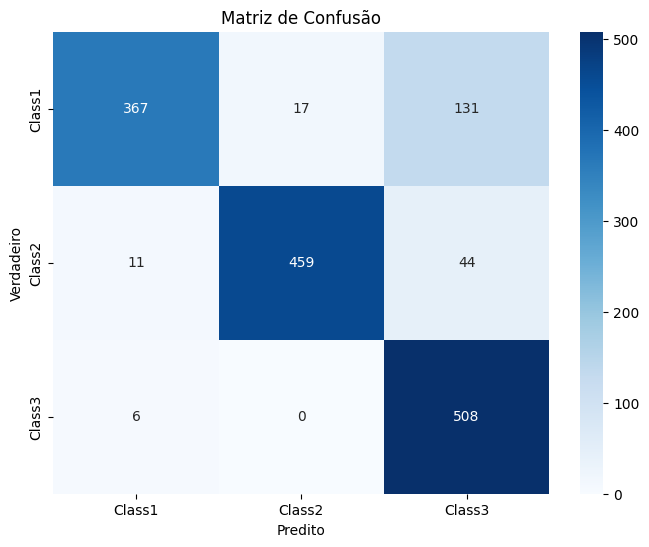

In [ ]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add,
                                     GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import Adam

# Caminho para os MFCCs salvos como imagens
mfcc_dir = "/content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/MFCC_NOVA"

# 1. Carregar imagens e rótulos
X = []
y = []

print("Carregando imagens...")
all_images = glob(os.path.join(mfcc_dir, "*.png"))
for img_path in tqdm(all_images):
    filename = os.path.basename(img_path)
    class_name = filename.split("_")[0]

    img = Image.open(img_path).convert("L")  # grayscale
    img = img.resize((216, 20))  # padronizar tamanho (largura x altura)
    img_array = np.array(img)

    X.append(img_array)
    y.append(class_name)

X = np.array(X)
y = np.array(y)

# 2. Preprocessamento
X = np.expand_dims(X, axis=-1)  # (N, H, W, 1)
X = X / 255.0

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# 3. Dividir em treino/val/teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, stratify=y_categorical, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Treino: {len(X_train)} | Validação: {len(X_val)} | Teste: {len(X_test)}")

# 4. Definir modelo ResNet-18 para imagens grayscale
def conv_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = conv_block(x, 64)
    x = conv_block(x, 64)
    x = conv_block(x, 128, stride=2)
    x = conv_block(x, 128)
    x = conv_block(x, 256, stride=2)
    x = conv_block(x, 256)
    x = conv_block(x, 512, stride=2)
    x = conv_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# 5. Construir e treinar o modelo
input_shape = X.shape[1:]
num_classes = y_categorical.shape[1]

model = build_resnet18(input_shape, num_classes)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# 6. Avaliação final
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🎯 Acurácia no conjunto de teste: {acc * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\nRelatório de Classificação:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

# REFAZENDO PARA LSTM

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from datetime import datetime
from tqdm import tqdm

# Parâmetros
TARGET_SR = 44100
WINDOW_SEC = 5.0
N_MELS = 128

# Caminhos
input_root = "/content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia"
output_root = os.path.join(input_root, "dataset_para_LSTM")
os.makedirs(output_root, exist_ok=True)

# ---------- Funções utilitárias ----------
def load_audio_resampled(file_path, sr=TARGET_SR):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def butter_bandpass_filter(data, sr, lowcut=50, highcut=8000, order=4):
    nyquist = 0.5 * sr
    b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
    return filtfilt(b, a, data)

def apply_envelope_filter(y, threshold_ratio=0.05):
    envelope = np.abs(hilbert(y))
    threshold = threshold_ratio * np.max(envelope)
    return np.where(envelope >= threshold, y, 0)

def split_audio_into_segments(y, sr, window_sec=5.0):
    segment_length = int(window_sec * sr)
    total_samples = len(y)
    segments = []
    for start in range(0, total_samples - segment_length + 1, segment_length):
        end = start + segment_length
        timestamp = start / sr  # tempo inicial em segundos
        segments.append((y[start:end], timestamp))
    return segments

def save_mel_spectrogram_image(segment, sr, output_path, n_mels=N_MELS):
    mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def extract_class_ship(file_path):
    parts = file_path.split(os.sep)
    class_name = parts[-3].strip()
    ship_name = parts[-2].strip()
    return class_name, ship_name

# ---------- Processamento dos arquivos de áudio ----------
def process_audio_file(file_path):
    try:
        y, sr = load_audio_resampled(file_path)
        y = butter_bandpass_filter(y, sr)
        y = apply_envelope_filter(y)

        class_name, ship_name = extract_class_ship(file_path)
        segments = split_audio_into_segments(y, sr, WINDOW_SEC)

        file_base = os.path.splitext(os.path.basename(file_path))[0]

        for idx, (segment, timestamp) in enumerate(segments):
            timestamp_str = datetime.utcfromtimestamp(timestamp).strftime("%Hh%Mm%Ss")
            file_name = f"{class_name}_{ship_name}_{file_base}_time{timestamp_str}.png"
            output_path = os.path.join(output_root, file_name)
            save_mel_spectrogram_image(segment, sr, output_path)

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")

def process_directory(input_dir):
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        if os.path.isdir(class_path) and class_folder.startswith("Class"):
            for root, _, files in os.walk(class_path):
                wav_files = [f for f in files if f.lower().endswith(".wav")]
                for file in tqdm(wav_files, desc=f"Processando {class_folder}"):
                    file_path = os.path.join(root, file)
                    process_audio_file(file_path)

# ---------- Execução ----------
print("Iniciando processamento...")
process_directory(input_root)
print("\nProcessamento finalizado. Espectrogramas salvos em:", output_root)


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from datetime import datetime
from tqdm import tqdm

# Parâmetros
TARGET_SR = 44100
WINDOW_SEC = 5.0
N_MELS = 128

# Caminhos
input_root = "/content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia"
output_root = os.path.join(input_root, "dataset_para_LSTM")
os.makedirs(output_root, exist_ok=True)

# ---------- Funções utilitárias ----------
def load_audio_resampled(file_path, sr=TARGET_SR):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def butter_bandpass_filter(data, sr, lowcut=50, highcut=8000, order=4):
    nyquist = 0.5 * sr
    b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
    return filtfilt(b, a, data)

def apply_envelope_filter(y, threshold_ratio=0.05):
    envelope = np.abs(hilbert(y))
    threshold = threshold_ratio * np.max(envelope)
    return np.where(envelope >= threshold, y, 0)

def split_audio_into_segments(y, sr, window_sec=5.0):
    segment_length = int(window_sec * sr)
    total_samples = len(y)
    segments = []
    for start in range(0, total_samples - segment_length + 1, segment_length):
        end = start + segment_length
        timestamp = start / sr  # tempo inicial em segundos
        segments.append((y[start:end], timestamp))
    return segments

def save_mel_spectrogram_image(segment, sr, output_path, n_mels=N_MELS):
    mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def extract_class_ship(file_path):
    parts = file_path.split(os.sep)
    class_name = parts[-3].strip()
    ship_name = parts[-2].strip()
    return class_name, ship_name

# ---------- Processamento dos arquivos de áudio ----------
def process_audio_file(file_path):
    try:
        y, sr = load_audio_resampled(file_path)
        y = butter_bandpass_filter(y, sr)
        y = apply_envelope_filter(y)

        class_name, ship_name = extract_class_ship(file_path)
        segments = split_audio_into_segments(y, sr, WINDOW_SEC)

        file_base = os.path.splitext(os.path.basename(file_path))[0]

        for idx, (segment, timestamp) in enumerate(segments):
            timestamp_str = datetime.utcfromtimestamp(timestamp).strftime("%Hh%Mm%Ss")
            file_name = f"{class_name}_{ship_name}_{file_base}_time{timestamp_str}.png"
            class_dir = os.path.join(output_root, class_name, ship_name)
            os.makedirs(class_dir, exist_ok=True)
            output_path = os.path.join(class_dir, file_name)
            save_mel_spectrogram_image(segment, sr, output_path)

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")

def process_directory(input_dir):
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        if os.path.isdir(class_path) and class_folder.startswith("Class"):
            for root, _, files in os.walk(class_path):
                wav_files = [f for f in files if f.lower().endswith(".wav")]
                for file in tqdm(wav_files, desc=f"Processando {class_folder}"):
                    file_path = os.path.join(root, file)
                    process_audio_file(file_path)

# ---------- Execução ----------
print("Iniciando processamento...")
process_directory(input_root)
print("\nProcessamento finalizado. Espectrogramas salvos em:", output_root)


Iniciando processamento...


Processando Class1: 0it [00:00, ?it/s]
Processando Class1: 100%|██████████| 11/11 [03:52<00:00, 21.14s/it]
Processando Class2: 0it [00:00, ?it/s]
Processando Class2: 100%|██████████| 26/26 [09:32<00:00, 22.00s/it]
Processando Class3: 0it [00:00, ?it/s]
Processando Class3:  29%|██▊       | 22/77 [07:45<25:56, 28.30s/it]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  30%|██▉       | 23/77 [07:46<18:01, 20.03s/it]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Process

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355183364.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354240738.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  32%|███▏      | 25/77 [07:47<08:35,  9.91s/it]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.



Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354273955.wav: The length of the input vector x must be greater than padlen, which is 27.


Processando Class3:  34%|███▍      | 26/77 [07:47<05:56,  7.00s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354310336.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  35%|███▌      | 27/77 [07:47<04:07,  4.96s/it]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  36%|███▋      | 28/77 [07:47<02:53,  3.53s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355238639.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354358040.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  38%|███▊      | 29/77 [07:47<02:01,  2.53s/it]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.



Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354533133.wav: The length of the input vector x must be greater than padlen, which is 27.


Processando Class3:  39%|███▉      | 30/77 [07:48<01:26,  1.83s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355291195.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  40%|████      | 31/77 [07:48<01:02,  1.35s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354582265.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  42%|████▏     | 32/77 [07:48<00:45,  1.01s/it]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355452590.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  43%|████▎     | 33/77 [07:48<00:34,  1.29it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355343752.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  44%|████▍     | 34/77 [07:48<00:26,  1.65it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354684977.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  45%|████▌     | 35/77 [07:49<00:20,  2.04it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355403588.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  47%|████▋     | 36/77 [07:49<00:16,  2.44it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355500845.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  48%|████▊     | 37/77 [07:49<00:14,  2.84it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354725037.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  49%|████▉     | 38/77 [07:49<00:12,  3.20it/s]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  51%|█████     | 39/77 [07:50<00:10,  3.59it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355553478.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354629990.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  52%|█████▏    | 40/77 [07:50<00:09,  3.79it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355604922.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  53%|█████▎    | 41/77 [07:50<00:09,  3.92it/s]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  55%|█████▍    | 42/77 [07:50<00:08,  4.23it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354778154.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354816674.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  56%|█████▌    | 43/77 [07:50<00:07,  4.51it/s]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  57%|█████▋    | 44/77 [07:51<00:07,  4.70it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354877043.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354412590.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  58%|█████▊    | 45/77 [07:51<00:06,  4.78it/s]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  60%|█████▉    | 46/77 [07:51<00:06,  4.94it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354453073.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354490622.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  61%|██████    | 47/77 [07:51<00:07,  4.27it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354935242.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  62%|██████▏   | 48/77 [07:52<00:09,  3.15it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355033584.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  64%|██████▎   | 49/77 [07:52<00:07,  3.52it/s]<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  65%|██████▍   | 50/77 [07:52<00:06,  3.89it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355081081.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354985308.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-28-ba543598e5bb>:22: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Processando Class3:  66%|██████▌   | 51/77 [07:52<00:06,  4.12it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355126030.wav: The length of the input vector x must be greater than padlen, which is 27.


Processando Class3:  70%|███████   | 54/77 [08:37<03:52, 10.10s/it]

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from datetime import datetime
from tqdm import tqdm

# Parâmetros
TARGET_SR = 44100
WINDOW_SEC = 5.0
N_MELS = 128

# Caminhos
input_root = "/content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia"
output_root = os.path.join(input_root, "dataset_para_LSTM")
os.makedirs(output_root, exist_ok=True)

# ---------- Funções utilitárias ----------
def load_audio_resampled(file_path, sr=TARGET_SR):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def butter_bandpass_filter(data, sr, lowcut=50, highcut=8000, order=4):
    nyquist = 0.5 * sr
    b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
    return filtfilt(b, a, data)

def apply_envelope_filter(y, threshold_ratio=0.05):
    envelope = np.abs(hilbert(y))
    threshold = threshold_ratio * np.max(envelope)
    return np.where(envelope >= threshold, y, 0)

def split_audio_into_segments(y, sr, window_sec=5.0):
    segment_length = int(window_sec * sr)
    total_samples = len(y)
    segments = []
    for start in range(0, total_samples - segment_length + 1, segment_length):
        end = start + segment_length
        timestamp = start / sr  # tempo inicial em segundos
        segments.append((y[start:end], timestamp))
    return segments

def save_mel_spectrogram_image(segment, sr, output_path, n_mels=N_MELS):
    mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def extract_class_ship(file_path):
    parts = file_path.split(os.sep)
    class_name = parts[-3].strip()
    ship_name = parts[-2].strip()
    return class_name, ship_name

# ---------- Processamento dos arquivos de áudio ----------
def process_audio_file(file_path):
    try:
        class_name, ship_name = extract_class_ship(file_path)
        file_base = os.path.splitext(os.path.basename(file_path))[0]
        timestamp_str = "00h00m00s"
        class_dir = os.path.join(output_root, class_name, ship_name)
        expected_file = os.path.join(class_dir, f"{class_name}_{ship_name}_{file_base}_time{timestamp_str}.png")

        # Verificar se já foi processado
        if os.path.exists(expected_file):
            print(f"[SKIP] {file_base} já processado.")
            return

        y, sr = load_audio_resampled(file_path)
        y = butter_bandpass_filter(y, sr)
        y = apply_envelope_filter(y)

        segments = split_audio_into_segments(y, sr, WINDOW_SEC)

        for idx, (segment, timestamp) in enumerate(segments):
            timestamp_str = datetime.utcfromtimestamp(timestamp).strftime("%Hh%Mm%Ss")
            file_name = f"{class_name}_{ship_name}_{file_base}_time{timestamp_str}.png"
            os.makedirs(class_dir, exist_ok=True)
            output_path = os.path.join(class_dir, file_name)
            save_mel_spectrogram_image(segment, sr, output_path)

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")

def process_directory(input_dir):
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_root, class_folder)
        if os.path.isdir(class_path) and class_folder.startswith("Class"):
            for root, _, files in os.walk(class_path):
                wav_files = [f for f in files if f.lower().endswith(".wav")]
                for file in tqdm(wav_files, desc=f"Processando {class_folder}"):
                    file_path = os.path.join(root, file)
                    process_audio_file(file_path)

# ---------- Execução ----------
print("Iniciando processamento...")
process_directory(input_root)
print("\nProcessamento finalizado. Espectrogramas salvos em:", output_root)


Iniciando processamento...


Processando Class1: 0it [00:00, ?it/s]
Processando Class1: 100%|██████████| 30/30 [00:00<00:00, 744.89it/s]


[SKIP] AUDIO (2) já processado.
[SKIP] AUDIO (3) já processado.
[SKIP] AUDIO (4) já processado.
[SKIP] AUDIO (30) já processado.
[SKIP] AUDIO (5) já processado.
[SKIP] AUDIO (6) já processado.
[SKIP] AUDIO (7) já processado.
[SKIP] AUDIO (8) já processado.
[SKIP] AUDIO (11) já processado.
[SKIP] AUDIO (9) já processado.
[SKIP] AUDIO (10) já processado.
[SKIP] AUDIO (12) já processado.
[SKIP] AUDIO (13) já processado.
[SKIP] AUDIO (14) já processado.
[SKIP] AUDIO (15) já processado.
[SKIP] AUDIO já processado.
[SKIP] AUDIO (16) já processado.
[SKIP] AUDIO (17) já processado.
[SKIP] AUDIO (18) já processado.
[SKIP] AUDIO (19) já processado.
[SKIP] AUDIO (20) já processado.
[SKIP] AUDIO (22) já processado.
[SKIP] AUDIO (23) já processado.
[SKIP] AUDIO (24) já processado.
[SKIP] AUDIO (25) já processado.
[SKIP] AUDIO (27) já processado.
[SKIP] AUDIO (28) já processado.
[SKIP] AUDIO (29) já processado.
[SKIP] AUDIO (26) já processado.
[SKIP] AUDIO (21) já processado.


Processando Class1: 100%|██████████| 19/19 [00:00<00:00, 678.71it/s]


[SKIP] AUDIO já processado.
[SKIP] AUDIO (2) já processado.
[SKIP] AUDIO (3) já processado.
[SKIP] AUDIO (4) já processado.
[SKIP] AUDIO (5) já processado.
[SKIP] AUDIO (6) já processado.
[SKIP] AUDIO (7) já processado.
[SKIP] AUDIO (8) já processado.
[SKIP] AUDIO (9) já processado.
[SKIP] AUDIO (10) já processado.
[SKIP] AUDIO (11) já processado.
[SKIP] AUDIO (12) já processado.
[SKIP] AUDIO (13) já processado.
[SKIP] AUDIO (14) já processado.
[SKIP] AUDIO (15) já processado.
[SKIP] AUDIO (16) já processado.
[SKIP] AUDIO (17) já processado.
[SKIP] AUDIO (18) já processado.
[SKIP] AUDIO (19) já processado.


Processando Class1: 100%|██████████| 11/11 [00:00<00:00, 846.09it/s]


[SKIP] sinal1 (7) já processado.
[SKIP] sinal1 (8) já processado.
[SKIP] sinal1 (9) já processado.
[SKIP] sinal1 já processado.
[SKIP] sinal1 (3) já processado.
[SKIP] sinal1 (4) já processado.
[SKIP] sinal1 (5) já processado.
[SKIP] sinal1 (6) já processado.
[SKIP] sinal1 (2) já processado.
[SKIP] AUDIO já processado.
[SKIP] AUDIO (2) já processado.


Processando Class2: 0it [00:00, ?it/s]
Processando Class2: 100%|██████████| 24/24 [00:00<00:00, 1173.15it/s]


[SKIP] 02 Faixa 2 já processado.
[SKIP] 01 Faixa 1 já processado.
[SKIP] 03 Faixa 3 já processado.
[SKIP] 04 Faixa 4 já processado.
[SKIP] 05 Faixa 5 já processado.
[SKIP] 07 Faixa 7 já processado.
[SKIP] 08 Faixa 8 já processado.
[SKIP] 06 Faixa 6 já processado.
[SKIP] 13 Faixa 13 já processado.
[SKIP] 11 Faixa 11 já processado.
[SKIP] 10 Faixa 10 já processado.
[SKIP] 12 Faixa 12 já processado.
[SKIP] 09 Faixa 9 já processado.
[SKIP] 16 Faixa 16 já processado.
[SKIP] 18 Faixa 18 já processado.
[SKIP] 14 Faixa 14 já processado.
[SKIP] 15 Faixa 15 já processado.
[SKIP] 17 Faixa 17 já processado.
[SKIP] 19 Faixa 19 já processado.
[SKIP] 20 Faixa 20 já processado.
[SKIP] 21 Faixa 21 já processado.
[SKIP] 23 Faixa 23 já processado.
[SKIP] 22 Faixa 22 já processado.
[SKIP] 24 Faixa 24 já processado.


Processando Class2: 100%|██████████| 25/25 [00:00<00:00, 762.48it/s]


[SKIP] AUDIO já processado.
[SKIP] AUDIO (2) já processado.
[SKIP] AUDIO (3) já processado.
[SKIP] AUDIO (4) já processado.
[SKIP] AUDIO (5) já processado.
[SKIP] AUDIO (6) já processado.
[SKIP] AUDIO (7) já processado.
[SKIP] AUDIO (8) já processado.
[SKIP] AUDIO (9) já processado.
[SKIP] AUDIO (10) já processado.
[SKIP] AUDIO (11) já processado.
[SKIP] AUDIO (12) já processado.
[SKIP] AUDIO (13) já processado.
[SKIP] AUDIO (15) já processado.
[SKIP] AUDIO (16) já processado.
[SKIP] AUDIO (17) já processado.
[SKIP] AUDIO (24) já processado.
[SKIP] AUDIO (25) já processado.
[SKIP] AUDIO (18) já processado.
[SKIP] AUDIO (19) já processado.
[SKIP] AUDIO (20) já processado.
[SKIP] AUDIO (21) já processado.
[SKIP] AUDIO (22) já processado.
[SKIP] AUDIO (23) já processado.
[SKIP] AUDIO (14) já processado.


Processando Class2: 100%|██████████| 3/3 [00:00<00:00, 815.33it/s]

[SKIP] sinal1 já processado.
[SKIP] sinal1 (2) já processado.
[SKIP] sinal1 (3) já processado.



Processando Class2: 100%|██████████| 26/26 [00:00<00:00, 834.25it/s]

[SKIP] track-T001 já processado.
[SKIP] track-T002 já processado.
[SKIP] track-T003 já processado.
[SKIP] track-T004 já processado.
[SKIP] track-T005 já processado.
[SKIP] track-T006 já processado.
[SKIP] track-T007 já processado.
[SKIP] track-T008 já processado.
[SKIP] track-T009 já processado.
[SKIP] track-T010 já processado.
[SKIP] track-T011 já processado.
[SKIP] track-T012 já processado.
[SKIP] track-T013 já processado.
[SKIP] track-T014 já processado.
[SKIP] track-T015 já processado.
[SKIP] track-T016 já processado.
[SKIP] track-T017 já processado.
[SKIP] track-T018 já processado.
[SKIP] track-T019 já processado.
[SKIP] track-T020 já processado.
[SKIP] track-T021 já processado.
[SKIP] track-T022 já processado.
[SKIP] track-T023 já processado.
[SKIP] track-T024 já processado.
[SKIP] track-T025 já processado.
[SKIP] track-T026 já processado.



Processando Class3: 0it [00:00, ?it/s]
Processando Class3: 100%|██████████| 16/16 [00:00<00:00, 838.99it/s]


[SKIP] AUDIO (15) já processado.
[SKIP] AUDIO (16) já processado.
[SKIP] AUDIO (3) já processado.
[SKIP] AUDIO (4) já processado.
[SKIP] AUDIO (5) já processado.
[SKIP] AUDIO (6) já processado.
[SKIP] AUDIO (7) já processado.
[SKIP] AUDIO (8) já processado.
[SKIP] AUDIO (9) já processado.
[SKIP] AUDIO já processado.
[SKIP] AUDIO (10) já processado.
[SKIP] AUDIO (2) já processado.
[SKIP] AUDIO (14) já processado.
[SKIP] AUDIO (11) já processado.
[SKIP] AUDIO (12) já processado.
[SKIP] AUDIO (13) já processado.


Processando Class3:   0%|          | 0/26 [00:00<?, ?it/s]

[SKIP] AUDIO já processado.
[SKIP] AUDIO (11) já processado.
[SKIP] AUDIO (2) já processado.
[SKIP] AUDIO (12) já processado.
[SKIP] AUDIO (3) já processado.
[SKIP] AUDIO (13) já processado.
[SKIP] AUDIO (4) já processado.
[SKIP] AUDIO (14) já processado.
[SKIP] AUDIO (7) já processado.
[SKIP] AUDIO (15) já processado.
[SKIP] AUDIO (6) já processado.
[SKIP] AUDIO (5) já processado.


Processando Class3: 100%|██████████| 26/26 [00:00<00:00, 870.81it/s]


[SKIP] AUDIO (8) já processado.
[SKIP] AUDIO (16) já processado.
[SKIP] AUDIO (9) já processado.
[SKIP] AUDIO (17) já processado.
[SKIP] AUDIO (26) já processado.
[SKIP] AUDIO (22) já processado.
[SKIP] AUDIO (10) já processado.
[SKIP] AUDIO (23) já processado.
[SKIP] AUDIO (24) já processado.
[SKIP] AUDIO (25) já processado.
[SKIP] AUDIO (18) já processado.
[SKIP] AUDIO (19) já processado.
[SKIP] AUDIO (20) já processado.
[SKIP] AUDIO (21) já processado.


Processando Class3: 100%|██████████| 4/4 [00:00<00:00, 760.01it/s]


[SKIP] AUDIO já processado.
[SKIP] AUDIO (2) já processado.
[SKIP] AUDIO (3) já processado.
[SKIP] AUDIO (4) já processado.


Processando Class3:   0%|          | 0/77 [00:00<?, ?it/s]

[SKIP] AUDIO_20241125182354171650 já processado.
[SKIP] AUDIO_20241125182352328549 já processado.
[SKIP] AUDIO_20241125182353148603 já processado.
[SKIP] AUDIO_20241125182352356450 já processado.
[SKIP] AUDIO_20241125182354107429 já processado.
[SKIP] AUDIO_20241125182352401680 já processado.
[SKIP] AUDIO_20241125182352488340 já processado.
[SKIP] AUDIO_20241125182352526909 já processado.
[SKIP] AUDIO_20241125182353080004 já processado.
[SKIP] AUDIO_20241125182353201908 já processado.
[SKIP] AUDIO_20241125182353347539 já processado.
[SKIP] AUDIO_20241125182353246131 já processado.
[SKIP] AUDIO_20241125182353414659 já processado.
[SKIP] AUDIO_20241125182353294018 já processado.
[SKIP] AUDIO_20241125182353478161 já processado.
[SKIP] AUDIO_20241125182353575920 já processado.
[SKIP] AUDIO_20241125182353765478 já processado.
[SKIP] AUDIO_20241125182353672234 já processado.
[SKIP] AUDIO_20241125182353828282 já processado.
[SKIP] AUDIO_20241125182353906805 já processado.
[SKIP] AUDIO_2024112

<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  30%|██▉       | 23/77 [00:03<00:08,  6.34it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  31%|███       | 24/77 [00:03<00:08,  6.29it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355183364.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354240738.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  32%|███▏      | 25/77 [00:04<00:08,  6.16it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354273955.wav: The length of the input vector x must be greater than padlen, which is 27.


Processando Class3:  34%|███▍      | 26/77 [00:04<00:08,  5.96it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354310336.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  35%|███▌      | 27/77 [00:04<00:08,  5.77it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355238639.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354358040.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  36%|███▋      | 28/77 [00:04<00:08,  5.63it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  38%|███▊      | 29/77 [00:04<00:08,  5.53it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFil

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354533133.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355291195.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  40%|████      | 31/77 [00:05<00:08,  5.30it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354582265.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  42%|████▏     | 32/77 [00:05<00:08,  5.20it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  43%|████▎     | 33/77 [00:05<00:08,  5.16it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355452590.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355343752.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  44%|████▍     | 34/77 [00:05<00:08,  4.98it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354684977.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  45%|████▌     | 35/77 [00:06<00:08,  4.91it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355403588.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  47%|████▋     | 36/77 [00:06<00:08,  4.70it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355500845.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  48%|████▊     | 37/77 [00:06<00:08,  4.61it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354725037.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  49%|████▉     | 38/77 [00:06<00:08,  4.55it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355553478.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  51%|█████     | 39/77 [00:06<00:08,  4.59it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354629990.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  52%|█████▏    | 40/77 [00:07<00:08,  4.52it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355604922.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  53%|█████▎    | 41/77 [00:07<00:07,  4.52it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  55%|█████▍    | 42/77 [00:07<00:07,  4.73it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354778154.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354816674.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  56%|█████▌    | 43/77 [00:07<00:07,  4.50it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354877043.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  57%|█████▋    | 44/77 [00:08<00:07,  4.51it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354412590.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  58%|█████▊    | 45/77 [00:08<00:06,  4.62it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  60%|█████▉    | 46/77 [00:08<00:06,  4.82it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354453073.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354490622.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  61%|██████    | 47/77 [00:08<00:06,  4.85it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  62%|██████▏   | 48/77 [00:08<00:05,  4.94it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354935242.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355033584.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  64%|██████▎   | 49/77 [00:09<00:05,  4.92it/s]<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  65%|██████▍   | 50/77 [00:09<00:05,  4.97it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355081081.wav: The length of the input vector x must be greater than padlen, which is 27.
Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182354985308.wav: The length of the input vector x must be greater than padlen, which is 27.


<ipython-input-1-281ab884cb6f>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processando Class3:  66%|██████▌   | 51/77 [00:09<00:05,  5.10it/s]

Erro ao processar /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/Class3/Ship4 Class3/AUDIO_20241125182355126030.wav: The length of the input vector x must be greater than padlen, which is 27.
[SKIP] AUDIO_20241125182606194608 já processado.
[SKIP] AUDIO_20241125182606239666 já processado.
[SKIP] AUDIO_20241125182606298835 já processado.


Processando Class3: 100%|██████████| 77/77 [09:23<00:00,  7.32s/it]


Processamento finalizado. Espectrogramas salvos em: /content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/dataset_para_LSTM


In [ ]:
# ======================
# PARTE 1: Pré-processamento para carregar imagens e rótulos
# ======================

import os
import numpy as np
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff

# Caminho para os espectrogramas
dataset_root = "/content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/dataset_para_LSTM"

# Coleta de dados
X = []
y = []

print("Carregando imagens...")
for class_folder in os.listdir(dataset_root):
    class_path = os.path.join(dataset_root, class_folder)
    if os.path.isdir(class_path):
        for ship_folder in os.listdir(class_path):
            ship_path = os.path.join(class_path, ship_folder)
            if os.path.isdir(ship_path):
                for img_file in glob(os.path.join(ship_path, "*.png")):
                    img = Image.open(img_file).convert("L")
                    img = img.resize((128, 128))  # padroniza o tamanho
                    img_array = np.array(img) / 255.0
                    X.append(img_array)
                    y.append(class_folder)

X = np.expand_dims(np.array(X), axis=-1)  # (N, H, W, 1)
y = np.array(y)

# Codificação
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42)

# ======================
# PARTE 2: Treinamento com Plotly
# ======================




model = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

# Salvar modelo
model.save("modelo_mel_cnn.h5")
np.save("classes_mel.npy", label_encoder.classes_)

# Plotly - Acurácia
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(y=history.history['accuracy'], name='Treino'))
fig_acc.add_trace(go.Scatter(y=history.history['val_accuracy'], name='Validação'))
fig_acc.update_layout(title="Acurácia por época", xaxis_title="Época", yaxis_title="Acurácia")
fig_acc.show()

# Plotly - Perda
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=history.history['loss'], name='Treino'))
fig_loss.add_trace(go.Scatter(y=history.history['val_loss'], name='Validação'))
fig_loss.update_layout(title="Perda por época", xaxis_title="Época", yaxis_title="Perda")
fig_loss.show()

Carregando imagens...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,131 (28.20 MB)

 Trainable params: 7,392,131 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4204 - loss: 1.2133 - val_accuracy: 0.5799 - val_loss: 0.8708
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5943 - loss: 0.8329 - val_accuracy: 0.7227 - val_loss: 0.6149
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7063 - loss: 0.6561 - val_accuracy: 0.7650 - val_loss: 0.5553
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7409 - loss: 0.5845 - val_accuracy: 0.7842 - val_loss: 0.4744
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7729 - loss: 0.5239 - val_accuracy: 0.7880 - val_loss: 0.4837
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7866 - loss: 0.4962 - val_accuracy: 0.8111 - val_loss: 0.4529
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8044 - loss: 0.4528 - val_accuracy: 0.8203 - val_loss: 0.4201
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8051 - loss: 0.4393 - 

In [ ]:

# PARTE 3: Avaliação do modelo
# ======================

# Recarregar modelo e classes
model = load_model("modelo_mel_cnn.h5")
class_names = np.load("classes_mel.npy")

# Previsões
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Relatório de classificação
print("\nRelatório de Classificação:")
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# Matriz de confusão com Plotly
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff

cm = confusion_matrix(y_true_labels, y_pred_labels)
fig = ff.create_annotated_heatmap(z=cm, x=class_names.tolist(), y=class_names.tolist(), colorscale='Blues')
fig.update_layout(title="Matriz de Confusão", xaxis_title="Predito", yaxis_title="Verdadeiro")
fig.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

      Class1       0.81      0.93      0.86       506
      Class2       0.93      0.89      0.91       436
      Class3       0.93      0.85      0.89       686

    accuracy                           0.89      1628
   macro avg       0.89      0.89      0.89      1628
weighted avg       0.89      0.89      0.89      1628



APRIMORANDO

In [ ]:
# ======================
# PARTE 1: Pré-processamento para carregar imagens e rótulos
# ======================

import os
import numpy as np
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff

# Caminho para os espectrogramas
dataset_root = "/content/drive/MyDrive/Projeto - Classificação de navios/pasta_tratada - Copia/dataset_para_LSTM"

# Coleta de dados
X = []
y = []

print("Carregando imagens...")
for class_folder in os.listdir(dataset_root):
    class_path = os.path.join(dataset_root, class_folder)
    if os.path.isdir(class_path):
        for ship_folder in os.listdir(class_path):
            ship_path = os.path.join(class_path, ship_folder)
            if os.path.isdir(ship_path):
                for img_file in glob(os.path.join(ship_path, "*.png")):
                    img = Image.open(img_file).convert("L")
                    img = img.resize((128, 128))  # padroniza o tamanho
                    img_array = np.array(img) / 255.0
                    X.append(img_array)
                    y.append(class_folder)

X = np.expand_dims(np.array(X), axis=-1)  # (N, H, W, 1)
y = np.array(y)

# Codificação
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42)

# ======================
# PARTE 2: Treinamento com Plotly (MobileNetV2)
# ======================

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Ajustar dados para 3 canais (RGB)
X_rgb = np.repeat(X, 3, axis=-1)  # de (N, 128, 128, 1) para (N, 128, 128, 3)
X_train_rgb, X_test_rgb, y_train, y_test = train_test_split(X_rgb, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42)

# Normalizar com preprocess_input
X_train_rgb = preprocess_input(X_train_rgb)
X_test_rgb = preprocess_input(X_test_rgb)

# Base do modelo
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # pode mudar para True para fine-tuning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(y_categorical.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Treinamento
history = model.fit(
    X_train_rgb, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_scheduler]
)

# Salvar modelo
model.save("modelo_mel_mobilenetv2.h5")
np.save("classes_mel.npy", label_encoder.classes_)

# Plotly - Acurácia
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(y=history.history['accuracy'], name='Treino'))
fig_acc.add_trace(go.Scatter(y=history.history['val_accuracy'], name='Validação'))
fig_acc.update_layout(title="Acurácia por época", xaxis_title="Época", yaxis_title="Acurácia")
fig_acc.show()

# Plotly - Perda
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=history.history['loss'], name='Treino'))
fig_loss.add_trace(go.Scatter(y=history.history['val_loss'], name='Validação'))
fig_loss.update_layout(title="Perda por época", xaxis_title="Época", yaxis_title="Perda")
fig_loss.show()

model = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

# Salvar modelo
model.save("modelo_mel_cnn.h5")
np.save("classes_mel.npy", label_encoder.classes_)

# Plotly - Acurácia
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(y=history.history['accuracy'], name='Treino'))
fig_acc.add_trace(go.Scatter(y=history.history['val_accuracy'], name='Validação'))
fig_acc.update_layout(title="Acurácia por época", xaxis_title="Época", yaxis_title="Acurácia")
fig_acc.show()

# Plotly - Perda
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=history.history['loss'], name='Treino'))
fig_loss.add_trace(go.Scatter(y=history.history['val_loss'], name='Validação'))
fig_loss.update_layout(title="Perda por época", xaxis_title="Época", yaxis_title="Perda")
fig_loss.show()


Carregando imagens...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.3697 - loss: 1.2138 - val_accuracy: 0.4601 - val_loss: 1.0892 - learning_rate: 0.0010
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3663 - loss: 1.1458 - val_accuracy: 0.3794 - val_loss: 1.0747 - learning_rate: 0.0010
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4003 - loss: 1.0980 - val_accuracy: 0.5000 - val_loss: 1.0579 - learning_rate: 0.0010
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4259 - loss: 1.0752 - val_accuracy: 0.3771 - val_loss: 1.0608 - learning_rate: 0.0010
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4278 - loss: 1.0755 - val_accuracy: 0.4539 - val_loss: 1.0425 - learning_rate: 0.0010
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4305 - loss: 1.0653 - val_accuracy: 0.3932 - val_loss: 1.0481 - learning_rate: 0.0010
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4218 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,131 (28.20 MB)

 Trainable params: 7,392,131 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3909 - loss: 1.2366 - val_accuracy: 0.6068 - val_loss: 0.8649
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6014 - loss: 0.8350 - val_accuracy: 0.6874 - val_loss: 0.6733
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6435 - loss: 0.7181 - val_accuracy: 0.7051 - val_loss: 0.5536
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6815 - loss: 0.6410 - val_accuracy: 0.8072 - val_loss: 0.5070
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7312 - loss: 0.5592 - val_accuracy: 0.8003 - val_loss: 0.4978
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7688 - loss: 0.5035 - val_accuracy: 0.8326 - val_loss: 0.4056
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7930 - loss: 0.4623 - val_accuracy: 0.8694 - val_loss: 0.3621
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8038 - loss: 0.4467 - val_accu

In [ ]:
# ======================
# PARTE 3: Avaliação do modelo
# ======================

# Recarregar modelo e classes
model = load_model("modelo_mel_cnn.h5")
class_names = np.load("classes_mel.npy")

# Previsões
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Relatório de classificação
print("Relatório de Classificação:")
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# Matriz de confusão com Plotly
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff

cm = confusion_matrix(y_true_labels, y_pred_labels)
fig = ff.create_annotated_heatmap(z=cm, x=class_names.tolist(), y=class_names.tolist(), colorscale='Blues')
fig.update_layout(title="Matriz de Confusão", xaxis_title="Predito", yaxis_title="Verdadeiro")
fig.show()



51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

      Class1       0.86      0.88      0.87       506
      Class2       0.93      0.92      0.92       436
      Class3       0.90      0.89      0.90       686

    accuracy                           0.90      1628
   macro avg       0.90      0.90      0.90      1628
weighted avg       0.90      0.90      0.90      1628



USAR RESNET 50

In [ ]:
# ==============================================================
# 0) INSTALAÇÕES (caso ainda não tenha)
# ==============================================================
# !pip install tensorflow pillow scikit-learn plotly --quiet

# ==============================================================
# 1) IMPORTAÇÕES
# ==============================================================
import os, glob, numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape,
                                     Bidirectional, LSTM, Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.figure_factory as ff
import plotly.graph_objects as go

# ==============================================================
# 2) CAMINHO DOS ESPECTROGRAMAS (ajuste se necessário)
# ==============================================================
DATA_DIR = "/content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec"

# ==============================================================
# 3) CARREGAMENTO E PRÉ-PROCESSAMENTO
# ==============================================================
imgs, labels = [], []

print(" Lendo espectrogramas …")
for path in glob.glob(os.path.join(DATA_DIR, "*.png")):
    # rótulo = primeira parte do nome (ex.: Class1_Ship1_seg0_...)
    label = os.path.basename(path).split("_")[0]

    img = Image.open(path).convert("L").resize((128, 128))
    imgs.append(np.array(img, dtype="float32") / 255.0)
    labels.append(label)

X = np.expand_dims(np.array(imgs), -1)          # (N, 128, 128, 1)
le = LabelEncoder()
y = to_categorical(le.fit_transform(labels))
num_classes = y.shape[1]

# divisões 80 / 10 / 10
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1111,  # 0.1111×0.9 ≈ 0.10
    stratify=y_train_full, random_state=42)

print(f"Treino: {len(X_train)} | Validação: {len(X_val)} | Teste: {len(X_test)}")

# ==============================================================
# 4) MODELO CNN‑LSTM
# ==============================================================
inputs = Input(shape=(128, 128, 1))

x = Conv2D(32, 3, padding="same", activation="relu")(inputs)
x = MaxPooling2D(2)(x)

x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)

x = Conv2D(128, 3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)                 # -> (batch, 16, 16, 128)

x = Reshape((16, 16 * 128))(x)         # sequência: 16 time‑steps, 2048 features
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(3e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# ==============================================================
# 5) TREINAMENTO
# ==============================================================
lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                             patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_sched],
    verbose=2
)

# --------------------------------------------------------------
# Função para plotar curvas
def plot_curve(metric, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history[metric], name="Treino"))
    fig.add_trace(go.Scatter(y=history.history[f"val_{metric}"], name="Validação"))
    fig.update_layout(title=title, xaxis_title="Época", yaxis_title=metric.capitalize())
    fig.show()

plot_curve("accuracy", "Acurácia por Época")
plot_curve("loss",      "Perda por Época")

# ==============================================================
# 6) AVALIAÇÃO NO TESTE
# ==============================================================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Acurácia (TESTE) = {test_acc:.4f}")

# matriz de confusão
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test,  axis=1)

cm = confusion_matrix(y_true, y_pred)
fig_cm = ff.create_annotated_heatmap(
    z=cm, x=le.classes_, y=le.classes_,
    colorscale="Blues", showscale=True, reversescale=True)
fig_cm.update_layout(title="Matriz de Confusão",
                     xaxis_title="Predito", yaxis_title="Verdadeiro")
fig_cm.show()

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# ==============================================================
# 7) SALVAR MODELO E CLASSES
# ==============================================================
model.save("cnn_lstm_navios.keras")
np.save("classes_navios.npy", le.classes_)
print("\nModelo salvo como 'cnn_lstm_navios.keras' e classes em 'classes_navios.npy'")


🔄 Lendo espectrogramas …
Treino: 2652 | Validação: 332 | Teste: 332


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,338,563 (8.92 MB)

 Trainable params: 2,338,563 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
83/83 - 8s - 91ms/step - accuracy: 0.4351 - loss: 1.0719 - val_accuracy: 0.5000 - val_loss: 1.0026 - learning_rate: 3.0000e-04
Epoch 2/60
83/83 - 2s - 22ms/step - accuracy: 0.4789 - loss: 1.0248 - val_accuracy: 0.4970 - val_loss: 0.9871 - learning_rate: 3.0000e-04
Epoch 3/60
83/83 - 2s - 22ms/step - accuracy: 0.4951 - loss: 1.0035 - val_accuracy: 0.5482 - val_loss: 0.8929 - learning_rate: 3.0000e-04
Epoch 4/60
83/83 - 2s - 22ms/step - accuracy: 0.5264 - loss: 0.9544 - val_accuracy: 0.6235 - val_loss: 0.8602 - learning_rate: 3.0000e-04
Epoch 5/60
83/83 - 2s - 22ms/step - accuracy: 0.5430 - loss: 0.9360 - val_accuracy: 0.5873 - val_loss: 0.8701 - learning_rate: 3.0000e-04
Epoch 6/60
83/83 - 2s - 22ms/step - accuracy: 0.5596 - loss: 0.9301 - val_accuracy: 0.6114 - val_loss: 0.8363 - learning_rate: 3.0000e-04
Epoch 7/60
83/83 - 2s - 22ms/step - accuracy: 0.5520 - loss: 0.9213 - val_accuracy: 0.5422 - val_loss: 0.9105 - learning_rate: 3.0000e-04
Epoch 8/60
83/83 - 2s - 22ms/step 


 Acurácia (TESTE) = 0.9247
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# ==============================================================
# 0) IMPORTAÇÕES
# ==============================================================
import os, glob, numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape,
                                     Bidirectional, LSTM, Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.figure_factory as ff
import plotly.graph_objects as go

# ==============================================================
# 1) CAMINHO DOS ESPECTROGRAMAS (.png)
# ==============================================================
DATA_DIR   = "/content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec"
MODEL_FILE = "cnn_lstm_navios.keras"
CLASSES_NP = "classes_navios.npy"

# ==============================================================
# 2) CARREGAMENTO E PRÉ‑PROCESSAMENTO
# ==============================================================
imgs, labels = [], []
print(" Lendo espectrogramas …")
for path in glob.glob(os.path.join(DATA_DIR, "*.png")):
    label = os.path.basename(path).split("_")[0]        # “ClassX”
    img   = Image.open(path).convert("L").resize((128, 128))
    imgs.append(np.array(img, dtype="float32") / 255.0)
    labels.append(label)

X = np.expand_dims(np.array(imgs), -1)                  # (N,128,128,1)
le = LabelEncoder()
y = to_categorical(le.fit_transform(labels))
num_classes = y.shape[1]

# ==============================================================
# 3) DIVISÃO 80 / 10 / 10
# ==============================================================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, stratify=y_train_full,
    random_state=42)                                    # ≈10 %

print(f"Treino: {len(X_train)}  |  Validação: {len(X_val)}  |  Teste: {len(X_test)}")

# ==============================================================
# 4) MODELO CNN‑LSTM
# ==============================================================
inputs = Input(shape=(128,128,1))

x = Conv2D(32, 3, padding="same", activation="relu")(inputs)
x = MaxPooling2D(2)(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Conv2D(128,3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)                  # (batch,16,16,128)

x = Reshape((16, 16*128))(x)            # (batch,time=16, feat=2048)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.4)(x)

outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(3e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# ==============================================================
# 5) TREINAMENTO
# ==============================================================
lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                             patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_sched],
    verbose=2
)

# --- curvas ---
def plot_curve(metric, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history[metric],
                             name="Treino", line=dict(width=2)))
    fig.add_trace(go.Scatter(y=history.history[f"val_{metric}"],
                             name="Validação", line=dict(width=2)))
    fig.update_layout(title=title, xaxis_title="Época",
                      yaxis_title=metric.capitalize(), template="plotly_white")
    fig.show()

plot_curve("accuracy", "Acurácia por Época")
plot_curve("loss",      "Perda por Época")

# ==============================================================
# 6) AVALIAÇÃO NO CONJUNTO DE TESTE
# ==============================================================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Acurácia FINAL (TESTE) = {test_acc:.4f}")

# ---------- Matriz de Confusão & Relatório ----------
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
classes = le.classes_.tolist()          # converte para list (evita ValueError)

fig_cm = ff.create_annotated_heatmap(
    z=cm, x=classes, y=classes,
    colorscale="Blues", showscale=True, reversescale=True)
fig_cm.update_layout(title="Matriz de Confusão",
                     xaxis_title="Classe Predita",
                     yaxis_title="Classe Verdadeira")
fig_cm.show()

print("\n  Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=classes))

# ==============================================================
# 7) SALVAR MODELO E CLASSES
# ==============================================================
model.save(MODEL_FILE)
np.save(CLASSES_NP, le.classes_)
print(f"\nModelo salvo: {MODEL_FILE}\nVetor de classes salvo: {CLASSES_NP}")


 Lendo espectrogramas …
Treino: 2652  |  Validação: 332  |  Teste: 332


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,338,563 (8.92 MB)

 Trainable params: 2,338,563 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
83/83 - 5s - 64ms/step - accuracy: 0.4348 - loss: 1.0706 - val_accuracy: 0.4970 - val_loss: 1.0029 - learning_rate: 3.0000e-04
Epoch 2/60
83/83 - 2s - 22ms/step - accuracy: 0.4744 - loss: 1.0359 - val_accuracy: 0.5000 - val_loss: 0.9854 - learning_rate: 3.0000e-04
Epoch 3/60
83/83 - 2s - 23ms/step - accuracy: 0.4898 - loss: 0.9969 - val_accuracy: 0.5241 - val_loss: 0.9063 - learning_rate: 3.0000e-04
Epoch 4/60
83/83 - 2s - 23ms/step - accuracy: 0.5106 - loss: 0.9628 - val_accuracy: 0.5572 - val_loss: 0.8856 - learning_rate: 3.0000e-04
Epoch 5/60
83/83 - 2s - 22ms/step - accuracy: 0.5298 - loss: 0.9408 - val_accuracy: 0.5723 - val_loss: 0.8748 - learning_rate: 3.0000e-04
Epoch 6/60
83/83 - 2s - 22ms/step - accuracy: 0.5456 - loss: 0.9416 - val_accuracy: 0.6235 - val_loss: 0.8611 - learning_rate: 3.0000e-04
Epoch 7/60
83/83 - 2s - 23ms/step - accuracy: 0.5683 - loss: 0.9205 - val_accuracy: 0.6145 - val_loss: 0.8811 - learning_rate: 3.0000e-04
Epoch 8/60
83/83 - 2s - 22ms/step 


 Acurácia FINAL (TESTE) = 0.9217
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step



  Relatório de Classificação:
              precision    recall  f1-score   support

      Class1       0.94      0.92      0.93        97
      Class2       0.92      0.91      0.91        88
      Class3       0.91      0.93      0.92       147

    accuracy                           0.92       332
   macro avg       0.92      0.92      0.92       332
weighted avg       0.92      0.92      0.92       332


Modelo salvo: cnn_lstm_navios.keras
Vetor de classes salvo: classes_navios.npy


In [ ]:
# ==============================================================
# CNN‑LSTM – Treino, Validação e Teste com Matriz de Confusão Escura
# ==============================================================
# Pré‑requisitos:
# pip install tensorflow pillow scikit-learn plotly --quiet

# ==============================================================
# 1) IMPORTAÇÕES
# ==============================================================
import os, glob, numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape,
                                     Bidirectional, LSTM, Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.figure_factory as ff
import plotly.graph_objects as go

# ==============================================================
# 2) PARÂMETROS E CAMINHOS
# ==============================================================
DATA_DIR   = "/content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec"
MODEL_FILE = "cnn_lstm_navios.keras"
CLASSES_NP = "classes_navios.npy"

# ==============================================================
# 3) CARREGAMENTO E PRÉ‑PROCESSAMENTO
# ==============================================================
imgs, labels = [], []
print(" Lendo espectrogramas …")
for path in glob.glob(os.path.join(DATA_DIR, "*.png")):
    label = os.path.basename(path).split("_")[0]        # ex: "Class1"
    img   = Image.open(path).convert("L").resize((128,128))
    imgs.append(np.array(img, dtype="float32")/255.0)
    labels.append(label)

X = np.expand_dims(np.array(imgs), -1)                 # (N,128,128,1)
le = LabelEncoder()
y  = to_categorical(le.fit_transform(labels))
num_classes = y.shape[1]

# ==============================================================
# 4) DIVISÃO 80/10/10
# ==============================================================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.1111,            # 0.1111 * 0.9 ≈ 0.10
    stratify=y_train_full,
    random_state=42)

print(f"Treino: {len(X_train)} | Validação: {len(X_val)} | Teste: {len(X_test)}")

# ==============================================================
# 5) DEFINIÇÃO DO MODELO CNN‑LSTM
# ==============================================================
inputs = Input(shape=(128,128,1))
x = Conv2D(32,3,activation="relu",padding="same")(inputs); x = MaxPooling2D(2)(x)
x = Conv2D(64,3,activation="relu",padding="same")(x);      x = MaxPooling2D(2)(x)
x = Conv2D(128,3,activation="relu",padding="same")(x);     x = MaxPooling2D(2)(x)  # (16,16,128)

x = Reshape((16,16*128))(x)                               # (16,2048)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.4)(x)

outputs = Dense(num_classes, activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(3e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# ==============================================================
# 6) TREINAMENTO
# ==============================================================
lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                             patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_sched],
    verbose=2
)

# Função de plotagem de curvas
def plot_curve(metric, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history[metric],   name="Treino"))
    fig.add_trace(go.Scatter(y=history.history[f"val_{metric}"], name="Validação"))
    fig.update_layout(title=title,
                      xaxis_title="Época",
                      yaxis_title=metric.capitalize(),
                      template="plotly_white")
    fig.show()

plot_curve("accuracy", "Acurácia por Época")
plot_curve("loss",      "Perda por Época")

# ==============================================================
# 7) AVALIAÇÃO NO CONJUNTO DE TESTE
# ==============================================================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Acurácia FINAL (TESTE) = {test_acc:.4f}")

# Geração de predições
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de Confusão (cores: mais escuro = maior valor)
cm = confusion_matrix(y_true, y_pred)
classes = le.classes_.tolist()

fig_cm = ff.create_annotated_heatmap(
    z=cm,
    x=classes,
    y=classes,
    colorscale="Blues",
    showscale=True
)
fig_cm.update_layout(title="Matriz de Confusão",
                     xaxis_title="Classe Predita",
                     yaxis_title="Classe Verdadeira",
                     template="plotly_white")
fig_cm.show()

# Relatório de Classificação
print("\n Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=classes))

# ==============================================================
# 8) SALVAR MODELO E VETOR DE CLASSES
# ==============================================================
model.save(MODEL_FILE)
np.save(CLASSES_NP, le.classes_)
print(f"\nModelo salvo em '{MODEL_FILE}'")
print(f"Classes salvas em '{CLASSES_NP}'")


 Lendo espectrogramas …
Treino: 2652 | Validação: 332 | Teste: 332


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,338,563 (8.92 MB)

 Trainable params: 2,338,563 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
83/83 - 8s - 95ms/step - accuracy: 0.4340 - loss: 1.0726 - val_accuracy: 0.4970 - val_loss: 1.0172 - learning_rate: 3.0000e-04
Epoch 2/60
83/83 - 2s - 22ms/step - accuracy: 0.4781 - loss: 1.0276 - val_accuracy: 0.4970 - val_loss: 0.9813 - learning_rate: 3.0000e-04
Epoch 3/60
83/83 - 2s - 22ms/step - accuracy: 0.4913 - loss: 0.9864 - val_accuracy: 0.5572 - val_loss: 0.8985 - learning_rate: 3.0000e-04
Epoch 4/60
83/83 - 2s - 22ms/step - accuracy: 0.5200 - loss: 0.9586 - val_accuracy: 0.5271 - val_loss: 0.8845 - learning_rate: 3.0000e-04
Epoch 5/60
83/83 - 2s - 22ms/step - accuracy: 0.5309 - loss: 0.9389 - val_accuracy: 0.5934 - val_loss: 0.8566 - learning_rate: 3.0000e-04
Epoch 6/60
83/83 - 2s - 22ms/step - accuracy: 0.5513 - loss: 0.9259 - val_accuracy: 0.5843 - val_loss: 0.8419 - learning_rate: 3.0000e-04
Epoch 7/60
83/83 - 2s - 22ms/step - accuracy: 0.5419 - loss: 0.9338 - val_accuracy: 0.5964 - val_loss: 0.8480 - learning_rate: 3.0000e-04
Epoch 8/60
83/83 - 2s - 22ms/step 


 Acurácia FINAL (TESTE) = 0.9217
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step



 Relatório de Classificação:
              precision    recall  f1-score   support

      Class1       0.89      0.97      0.93        97
      Class2       0.93      0.90      0.91        88
      Class3       0.94      0.90      0.92       147

    accuracy                           0.92       332
   macro avg       0.92      0.92      0.92       332
weighted avg       0.92      0.92      0.92       332


Modelo salvo em 'cnn_lstm_navios.keras'
Classes salvas em 'classes_navios.npy'


In [ ]:
# ==============================================================
# 8) SALVAR MODELO E VETOR DE CLASSES (ATUALIZADO)
# ==============================================================

MODEL_DIR = "/content/drive/MyDrive/Projeto - Classificação de navios/MELHORES MODELOS"
MODEL_FILE = os.path.join(MODEL_DIR, "cnn_lstm_navios.keras")
CLASSES_NP = os.path.join(MODEL_DIR, "classes_navios.npy")

# Criar diretório se não existir
os.makedirs(MODEL_DIR, exist_ok=True)

# Salvar modelo e rótulos
model.save(MODEL_FILE)
np.save(CLASSES_NP, le.classes_)

print(f"\n Modelo salvo em: {MODEL_FILE}")
print(f" Classes salvas em: {CLASSES_NP}")



 Modelo salvo em: /content/drive/MyDrive/Projeto - Classificação de navios/MELHORES MODELOS/cnn_lstm_navios.keras
 Classes salvas em: /content/drive/MyDrive/Projeto - Classificação de navios/MELHORES MODELOS/classes_navios.npy


COM 100

In [ ]:
# ==============================================================
# CNN‑LSTM – Treino, Validação e Teste com Matriz de Confusão Escura
# ==============================================================
# Pré‑requisitos:
# pip install tensorflow pillow scikit-learn plotly --quiet

# ==============================================================
# 1) IMPORTAÇÕES
# ==============================================================
import os, glob, numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape,
                                     Bidirectional, LSTM, Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.figure_factory as ff
import plotly.graph_objects as go

# ==============================================================
# 2) PARÂMETROS E CAMINHOS
# ==============================================================
DATA_DIR   = "/content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec"
MODEL_FILE = "cnn_lstm_navios.keras"
CLASSES_NP = "classes_navios.npy"

# ==============================================================
# 3) CARREGAMENTO E PRÉ‑PROCESSAMENTO
# ==============================================================
imgs, labels = [], []
print(" Lendo espectrogramas …")
for path in glob.glob(os.path.join(DATA_DIR, "*.png")):
    label = os.path.basename(path).split("_")[0]        # ex: "Class1"
    img   = Image.open(path).convert("L").resize((128,128))
    imgs.append(np.array(img, dtype="float32")/255.0)
    labels.append(label)

X = np.expand_dims(np.array(imgs), -1)                 # (N,128,128,1)
le = LabelEncoder()
y  = to_categorical(le.fit_transform(labels))
num_classes = y.shape[1]

# ==============================================================
# 4) DIVISÃO 80/10/10
# ==============================================================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.1111,            # 0.1111 * 0.9 ≈ 0.10
    stratify=y_train_full,
    random_state=42)

print(f"Treino: {len(X_train)} | Validação: {len(X_val)} | Teste: {len(X_test)}")

# ==============================================================
# 5) DEFINIÇÃO DO MODELO CNN‑LSTM
# ==============================================================
inputs = Input(shape=(128,128,1))
x = Conv2D(32,3,activation="relu",padding="same")(inputs); x = MaxPooling2D(2)(x)
x = Conv2D(64,3,activation="relu",padding="same")(x);      x = MaxPooling2D(2)(x)
x = Conv2D(128,3,activation="relu",padding="same")(x);     x = MaxPooling2D(2)(x)  # (16,16,128)

x = Reshape((16,16*128))(x)                               # (16,2048)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.4)(x)

outputs = Dense(num_classes, activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(3e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# ==============================================================
# 6) TREINAMENTO
# ==============================================================
lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                             patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_sched],
    verbose=2
)

# Função de plotagem de curvas
def plot_curve(metric, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history[metric],   name="Treino"))
    fig.add_trace(go.Scatter(y=history.history[f"val_{metric}"], name="Validação"))
    fig.update_layout(title=title,
                      xaxis_title="Época",
                      yaxis_title=metric.capitalize(),
                      template="plotly_white")
    fig.show()

plot_curve("accuracy", "Acurácia por Época")
plot_curve("loss",      "Perda por Época")

# ==============================================================
# 7) AVALIAÇÃO NO CONJUNTO DE TESTE
# ==============================================================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Acurácia FINAL (TESTE) = {test_acc:.4f}")

# Geração de predições
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de Confusão (cores: mais escuro = maior valor)
cm = confusion_matrix(y_true, y_pred)
classes = le.classes_.tolist()

fig_cm = ff.create_annotated_heatmap(
    z=cm,
    x=classes,
    y=classes,
    colorscale="Blues",
    showscale=True
)
fig_cm.update_layout(title="Matriz de Confusão",
                     xaxis_title="Classe Predita",
                     yaxis_title="Classe Verdadeira",
                     template="plotly_white")
fig_cm.show()

# Relatório de Classificação
print("\n Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=classes))

# ==============================================================
# 8) SALVAR MODELO E VETOR DE CLASSES
# ==============================================================
model.save(MODEL_FILE)
np.save(CLASSES_NP, le.classes_)
print(f"\nModelo salvo em '{MODEL_FILE}'")
print(f"Classes salvas em '{CLASSES_NP}'")


 Lendo espectrogramas …
Treino: 2652 | Validação: 332 | Teste: 332


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,338,563 (8.92 MB)

 Trainable params: 2,338,563 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
83/83 - 9s - 106ms/step - accuracy: 0.4468 - loss: 1.0601 - val_accuracy: 0.5000 - val_loss: 1.0098 - learning_rate: 3.0000e-04
Epoch 2/200
83/83 - 2s - 21ms/step - accuracy: 0.4751 - loss: 1.0341 - val_accuracy: 0.4970 - val_loss: 0.9987 - learning_rate: 3.0000e-04
Epoch 3/200
83/83 - 2s - 21ms/step - accuracy: 0.4887 - loss: 1.0165 - val_accuracy: 0.4910 - val_loss: 0.9615 - learning_rate: 3.0000e-04
Epoch 4/200
83/83 - 2s - 21ms/step - accuracy: 0.5023 - loss: 0.9668 - val_accuracy: 0.5843 - val_loss: 0.8999 - learning_rate: 3.0000e-04
Epoch 5/200
83/83 - 2s - 22ms/step - accuracy: 0.5260 - loss: 0.9408 - val_accuracy: 0.5633 - val_loss: 0.8716 - learning_rate: 3.0000e-04
Epoch 6/200
83/83 - 2s - 22ms/step - accuracy: 0.5407 - loss: 0.9351 - val_accuracy: 0.5151 - val_loss: 0.9445 - learning_rate: 3.0000e-04
Epoch 7/200
83/83 - 2s - 21ms/step - accuracy: 0.5532 - loss: 0.9319 - val_accuracy: 0.5873 - val_loss: 0.8586 - learning_rate: 3.0000e-04
Epoch 8/200
83/83 - 2s - 2


 Acurácia FINAL (TESTE) = 0.9157
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



 Relatório de Classificação:
              precision    recall  f1-score   support

      Class1       0.90      0.95      0.92        97
      Class2       0.94      0.90      0.92        88
      Class3       0.91      0.90      0.91       147

    accuracy                           0.92       332
   macro avg       0.92      0.92      0.92       332
weighted avg       0.92      0.92      0.92       332


Modelo salvo em 'cnn_lstm_navios.keras'
Classes salvas em 'classes_navios.npy'


k fold

In [ ]:
# ==============================================================
# CNN‑LSTM com Stratified K-Fold Cross‑Validation
# ==============================================================
# Pré‑requisitos:
# pip install tensorflow pillow scikit-learn plotly --quiet

# ==============================================================
# 1) IMPORTAÇÕES
# ==============================================================
import os, glob, numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape,
                                     Bidirectional, LSTM, Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.graph_objects as go
import plotly.figure_factory as ff

# ==============================================================
# 2) PARÂMETROS E CAMINHOS
# ==============================================================
DATA_DIR   = "/content/drive/MyDrive/Projeto - Classificação de navios/Mel-spec"
MODEL_FILE = "cnn_lstm_navios.keras"
CLASSES_NP = "classes_navios.npy"
N_FOLDS    = 5
EPOCHS     = 200
BATCH_SIZE = 32

# ==============================================================
# 3) CARREGAMENTO E PRÉ‑PROCESSAMENTO
# ==============================================================
imgs, labels = [], []
print(" Lendo espectrogramas …")
for path in glob.glob(os.path.join(DATA_DIR, "*.png")):
    label = os.path.basename(path).split("_")[0]  # ex: "Class1"
    img   = Image.open(path).convert("L").resize((128,128))
    imgs.append(np.array(img, dtype="float32")/255.0)
    labels.append(label)

X = np.expand_dims(np.array(imgs), -1)           # (N,128,128,1)
le = LabelEncoder()
y_raw = le.fit_transform(labels)                 # (N,)
y     = to_categorical(y_raw)                    # (N, num_classes)
num_classes = y.shape[1]
np.save(CLASSES_NP, le.classes_)                  # salva classes

print(f"Total de amostras: {len(X)} | Classes: {le.classes_.tolist()}")

# ==============================================================
# 4) FUNÇÃO PARA CRIAR O MODELO
# ==============================================================
def create_model():
    inputs = Input(shape=(128,128,1))
    x = Conv2D(32,3,activation="relu",padding="same")(inputs); x = MaxPooling2D(2)(x)
    x = Conv2D(64,3,activation="relu",padding="same")(x);      x = MaxPooling2D(2)(x)
    x = Conv2D(128,3,activation="relu",padding="same")(x);     x = MaxPooling2D(2)(x)  # (16,16,128)

    x = Reshape((16,16*128))(x)                                # (16,2048)
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.4)(x)

    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(3e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ==============================================================
# 5) STRATIFIED K-FOLD
# ==============================================================
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold, loss_per_fold = [], []

for train_idx, val_idx in skf.split(X, y_raw):
    print(f"\n=== Fold {fold_no}/{N_FOLDS} ===")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # instancia e treina um novo modelo
    model = create_model()
    lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                 patience=3, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[lr_sched],
        verbose=2
    )

    # avalia neste fold
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold_no} — Loss: {scores[0]:.4f} — Acc: {scores[1]:.4f}")
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])

    # opcional: plot de curvas para este fold
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history["accuracy"], name="Treino"))
    fig.add_trace(go.Scatter(y=history.history["val_accuracy"], name="Validação"))
    fig.update_layout(
        title=f"Fold {fold_no} — Acurácia por Época",
        xaxis_title="Época",
        yaxis_title="Acurácia",
        template="plotly_white"
    )
    fig.show()

    fold_no += 1

# ==============================================================
# 6) RESULTADOS GERAIS
# ==============================================================
print("\n=== Resultados Médios entre Folds ===")
print(f"Acurácia média : {np.mean(acc_per_fold):.4f} ± {np.std(acc_per_fold):.4f}")
print(f"Perda média     : {np.mean(loss_per_fold):.4f} ± {np.std(loss_per_fold):.4f}")

# ==============================================================
# 7) TREINO FINAL NO CONJUNTO COMPLETO E TESTE (opcional)
#    Se você tiver um conjunto de teste separado, pode treinar
#    no X e y completos e depois avaliar em X_test.
# ==============================================================
# model_final = create_model()
# model_final.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# model_final.save(MODEL_FILE)
# print(f"\nModelo final salvo em '{MODEL_FILE}'")
